<a href="https://colab.research.google.com/github/honeyd3wy/bc_projects/blob/master/Section%202/section2_pj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 2 Project : Telco Customer Churn Prediction

In [ ]:
! pip install chart_studio

In [ ]:
! pip install -U pandas-profiling

In [ ]:
! pip install category_encoders
! pip install --upgrade git+https://github.com/scikit-learn-contrib/category_encoders

In [ ]:
! pip install eli5

In [ ]:
!pip install pdpbox
!pip install shap

In [ ]:
# 경고문 무시하기
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# importing library

import numpy as np # linear algebra
from scipy import stats # statistic library
import pandas as pd # To table manipulations
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode

#Importing the auxiliar and preprocessing librarys 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate
from category_encoders import OneHotEncoder, OrdinalEncoder

#Models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### ***Data Description***
**[Target]**
- `Churn` : 고객의 이탈 여부`(Yes or No)` 

**[Features]**
- `customerID` : 고객의 ID
- `gender` : 고객의 성별
- `SeniorCitizen` : 고객이 노인인지 여부 `(0, 1)`
- `Partner` : 고객에게 파트너가 있는지 여부 `(Yes, No)`
- `Dependents` : 고객에게 피 부양자가 있는지 여부 `(Yes, No)`
- `tenure` : 고객이 우리 통신사에 머문 기간(월)
- `PhoneService` : 고객이 휴대전화 서비스를 이용하는지 여부 `(Yes, No)`
- `MultipleLines` : 고객에게 여러 회선이 있는지 여부`(Yes, No, No phone service)`
- `InternetService` : 고객의 인터넷 서비스 공급자`(DSL, Fiber optic(광섬유), No)`
- `OnlineSecurity` : 고객의 온라인 보안 여부`(Yes, No, No internet service)`
- `OnlineBackup`: 고객의 온라인 백업 여부`(Yes, No, No internet service)`
- `DeviceProtection` : 고객에게 장치 보호 기능이 있는지 여부`(Yes, No, No internet service)`
- `TechSupport` : 고객에게 기술 지원이 있는지 여부`(Yes, No, No internet service)`
- `StreamingTV` : 고객에게 스트리밍 TV가 있는지 여부`(Yes, No, No internet service)`
- `StreamingMovies` : 고객에게 스트리밍 영화가 있는지 여부`(Yes, No, No internet service)`
- `Contract` : 고객의 계약 기간`(Month-to-month, One year, Two year)`
- `PaperlessBilling` : 고객이 종이 없는 청구서를 가지고 있는지 여부`(Yes, No)`
- `PaymentMethod` : 고객의 결제 방법

        (Electronic check(전자 수표), Mailed check(우편 수표),
        Bank transfer (automatic)(은행 송금(자동)), Credit card (automatic)(신용카드(자동)))

- `MonthlyCharges` : 고객에게 매월 청구된 금액
- `TotalCharges` : 고객에게 청구된 총 금액









# Data Preprocessing

In [ ]:
## 데이터 불러오기
import pandas as pd

url = 'https://docs.google.com/uc?export=download&id=1OKV8Wym_meJYKfVZBW_sVHOTejjQIFj_'
df = pd.read_csv(url)

## 데이터 전처리

# target 데이터 
df['Churn'] = np.where(df['Churn'] == 'Yes', 1, 0)

# ID 값 드랍
df.drop('customerID', axis=1, inplace=True)

# numeric으로 형변환
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['SeniorCitizen'] = df['SeniorCitizen'].astype('O')

nulls_id = df[df['TotalCharges'].isnull()].index.tolist()

# null값은 신규 고객으로 보이므로 월 납부요금으로 결측치를 채워준다.
df.loc[df.index.isin(nulls_id), 'TotalCharges'] = df.loc[df.index.isin(nulls_id), 'MonthlyCharges']

## 타겟, 특성 나누기
target = 'Churn'
features = df.columns.tolist()
features.remove(target)
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_features = list(set(features).difference(num_features))

In [ ]:
import pandas as pd

url = 'https://docs.google.com/uc?export=download&id=1OKV8Wym_meJYKfVZBW_sVHOTejjQIFj_'
df = pd.read_csv(url)

In [ ]:
df

customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
0     7590-VHVEG  Female              0  ...          29.85        29.85     No
1     5575-GNVDE    Male              0  ...          56.95       1889.5     No
2     3668-QPYBK    Male              0  ...          53.85       108.15    Yes
3     7795-CFOCW    Male              0  ...          42.30      1840.75     No
4     9237-HQITU  Female              0  ...          70.70       151.65    Yes
...          ...     ...            ...  ...            ...          ...    ...
7038  6840-RESVB    Male              0  ...          84.80       1990.5     No
7039  2234-XADUH  Female              0  ...         103.20       7362.9     No
7040  4801-JZAZL  Female              0  ...          29.60       346.45     No
7041  8361-LTMKD    Male              1  ...          74.40        306.6    Yes
7042  3186-AJIEK    Male              0  ...         105.65       6844.5     No

[7043 rows x 21 columns]

# EDA

## 1. Pandas Profiling

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 2. target class 분포 파악 (by `churn`)


In [ ]:
df[target].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

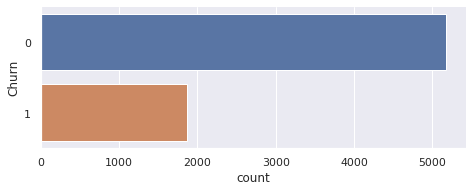

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme()
sns.catplot(y=df[target],  data = df, kind='count', height=2.6, aspect=2.5, orient='h');

## 3. numeric features 분포 파악

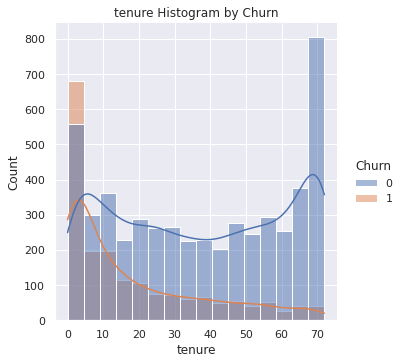

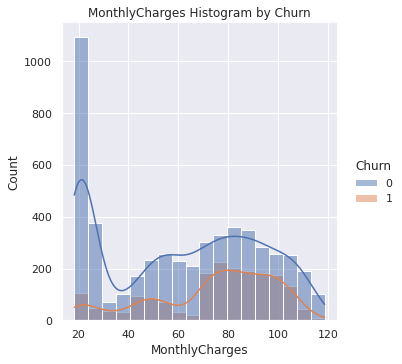

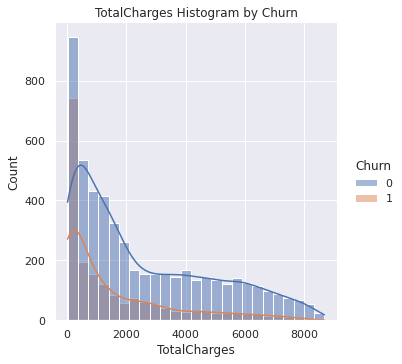

In [ ]:
sns.set_theme()
for s in num_features:
    ax = sns.displot(df, x=s, hue="Churn", kde=True);
    plt.title('{} Histogram by Churn'.format(s))

## 4. categorical features 분포 파악 (by `churn`)

In [ ]:
def Churn_by_feature_countplot(df, col):
    chrun_to_feature = df.groupby(['Churn', col]).count()
    chrun_to_feature = chrun_to_feature.mean(axis=1).reset_index().rename(columns={0:'Counts'}).pivot_table(index=col, columns='Churn', values='Counts')
    chrun_to_feature['Ratio(%)'] = (chrun_to_feature[1] / (chrun_to_feature[0]+chrun_to_feature[1]))*100

    sns.set_theme()
    plt.figure(figsize=(10,6))
    ax = sns.countplot(data=df, x=col, hue="Churn")

    plt.title('Churn count by {}'.format(col))
    return chrun_to_feature

In [ ]:
len(cat_features)

16

Churn               0       1   Ratio(%)
SeniorCitizen                           
0              4508.0  1393.0  23.606168
1               666.0   476.0  41.681261

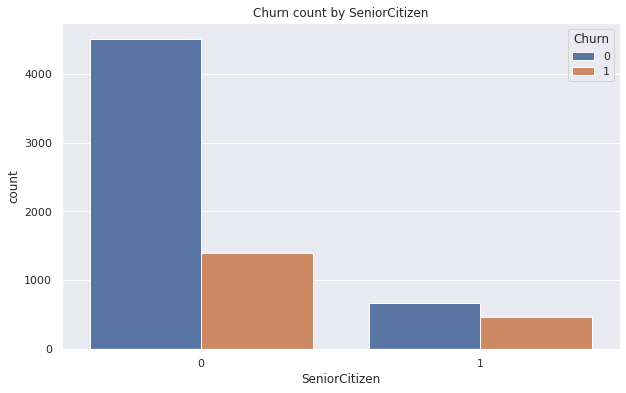

In [ ]:
Churn_by_feature_countplot(df, cat_features[0])

Churn                 0       1   Ratio(%)
InternetService                           
DSL              1962.0   459.0  18.959108
Fiber optic      1799.0  1297.0  41.892765
No               1413.0   113.0   7.404980

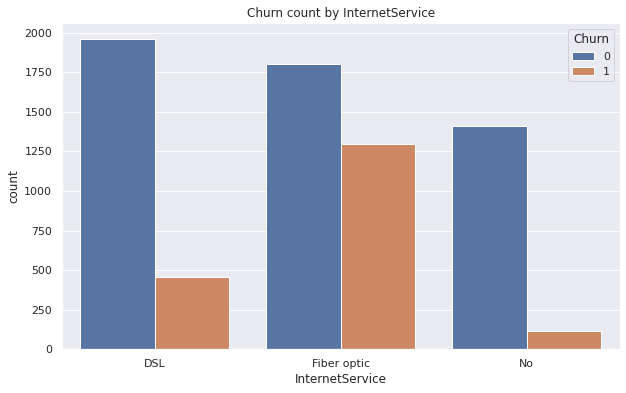

In [ ]:
Churn_by_feature_countplot(df, cat_features[1])

Churn                     0      1   Ratio(%)
StreamingMovies                              
No                   1847.0  938.0  33.680431
No internet service  1413.0  113.0   7.404980
Yes                  1914.0  818.0  29.941435

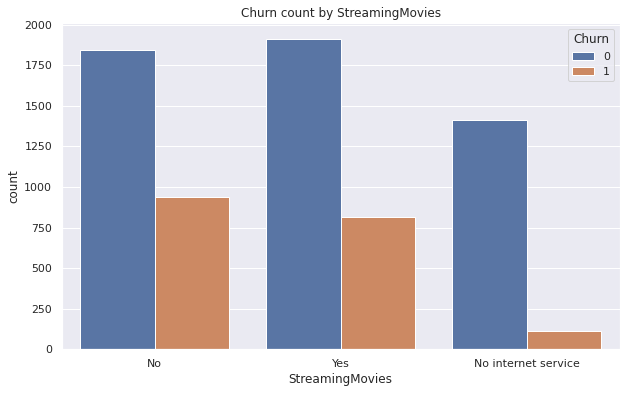

In [ ]:
Churn_by_feature_countplot(df, cat_features[2])

Churn         0       1   Ratio(%)
Partner                           
No       2441.0  1200.0  32.957979
Yes      2733.0   669.0  19.664903

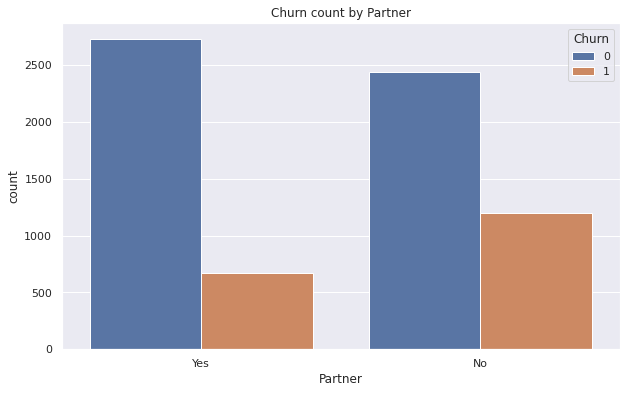

In [ ]:
Churn_by_feature_countplot(df, cat_features[3])

Churn        0      1   Ratio(%)
gender                          
Female  2549.0  939.0  26.920872
Male    2625.0  930.0  26.160338

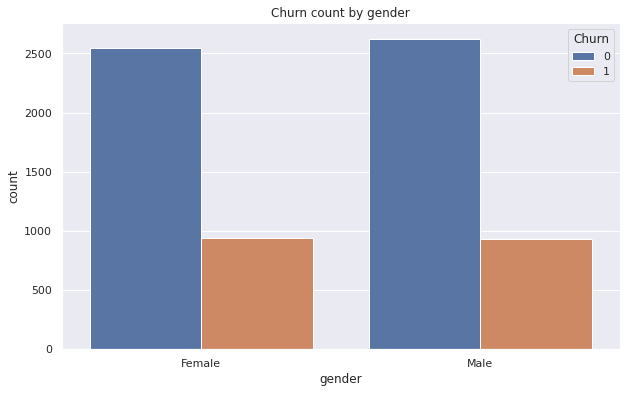

In [ ]:
Churn_by_feature_countplot(df, cat_features[4])

Churn                  0      1   Ratio(%)
MultipleLines                             
No                2541.0  849.0  25.044248
No phone service   512.0  170.0  24.926686
Yes               2121.0  850.0  28.609896

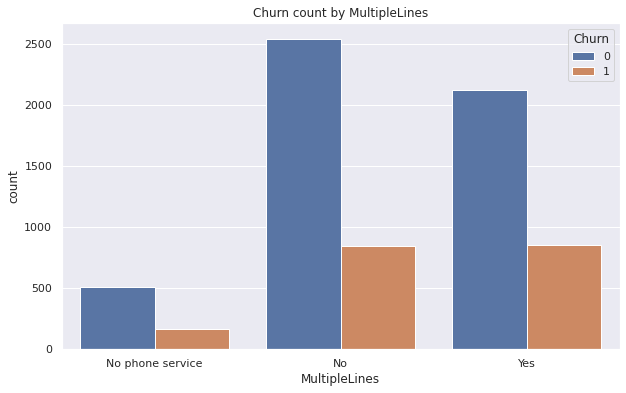

In [ ]:
Churn_by_feature_countplot(df, cat_features[5])

Churn            0       1   Ratio(%)
Dependents                           
No          3390.0  1543.0  31.279140
Yes         1784.0   326.0  15.450237

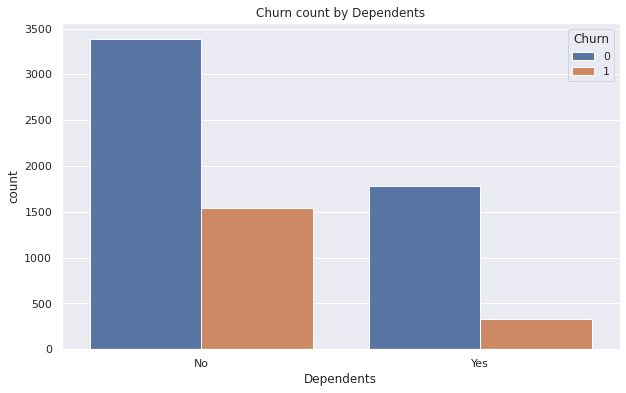

In [ ]:
Churn_by_feature_countplot(df, cat_features[6])

Churn                0       1   Ratio(%)
Contract                                 
Month-to-month  2220.0  1655.0  42.709677
One year        1307.0   166.0  11.269518
Two year        1647.0    48.0   2.831858

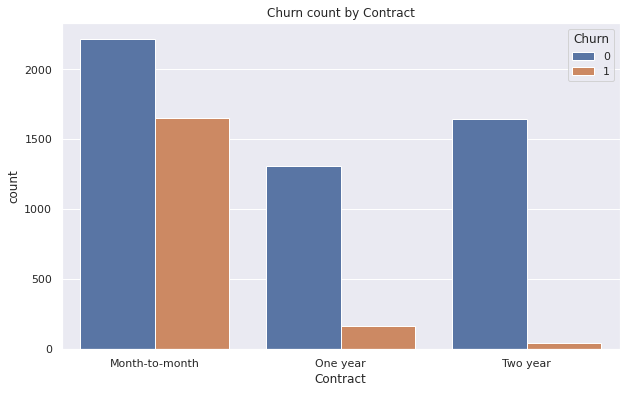

In [ ]:
Churn_by_feature_countplot(df, cat_features[7])

Churn                     0      1   Ratio(%)
StreamingTV                                  
No                   1868.0  942.0  33.523132
No internet service  1413.0  113.0   7.404980
Yes                  1893.0  814.0  30.070188

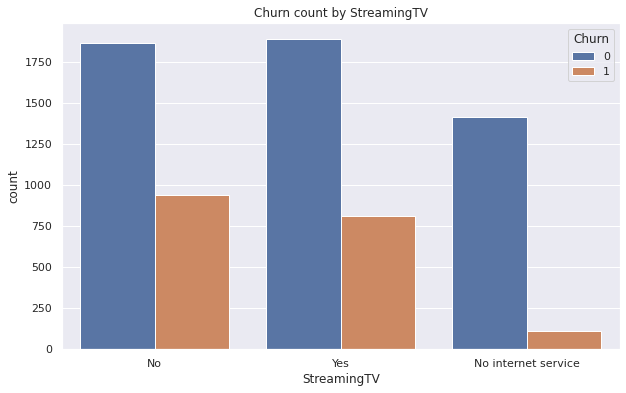

In [ ]:
Churn_by_feature_countplot(df, cat_features[8])

Churn              0       1   Ratio(%)
PhoneService                           
No             512.0   170.0  24.926686
Yes           4662.0  1699.0  26.709637

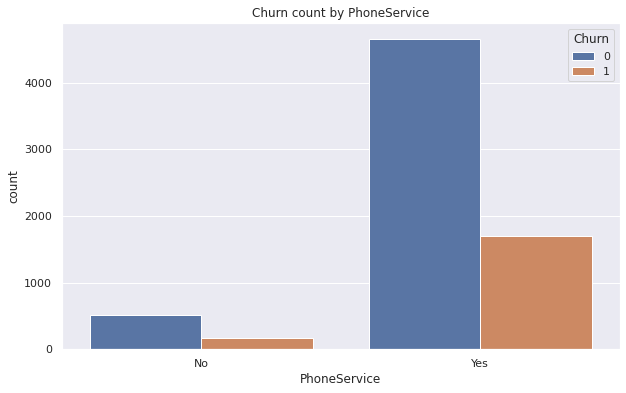

In [ ]:
Churn_by_feature_countplot(df, cat_features[9])

Churn                     0       1   Ratio(%)
OnlineBackup                                  
No                   1855.0  1233.0  39.928756
No internet service  1413.0   113.0   7.404980
Yes                  1906.0   523.0  21.531494

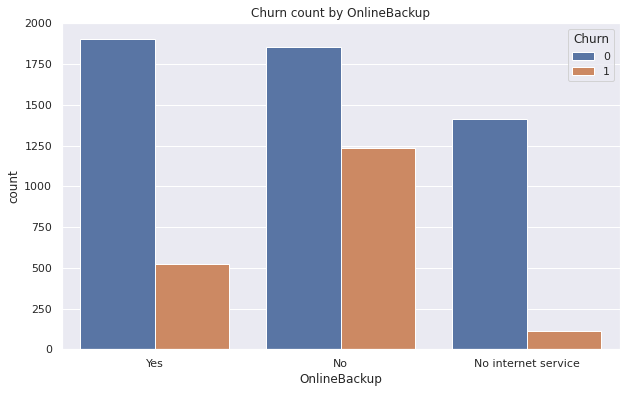

In [ ]:
Churn_by_feature_countplot(df, cat_features[10])

Churn                     0       1   Ratio(%)
OnlineSecurity                                
No                   2037.0  1461.0  41.766724
No internet service  1413.0   113.0   7.404980
Yes                  1724.0   295.0  14.611194

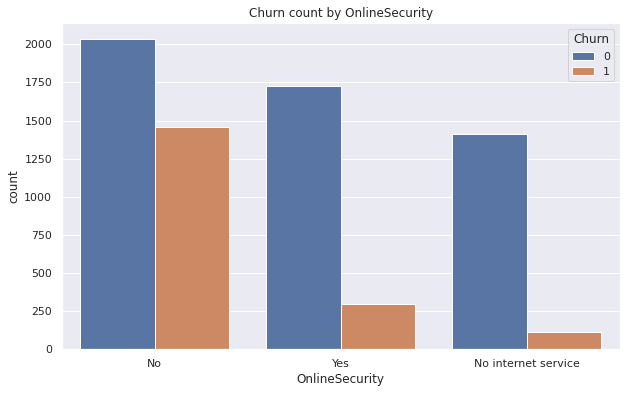

In [ ]:
Churn_by_feature_countplot(df, cat_features[11])

Churn                     0       1   Ratio(%)
TechSupport                                   
No                   2027.0  1446.0  41.635474
No internet service  1413.0   113.0   7.404980
Yes                  1734.0   310.0  15.166341

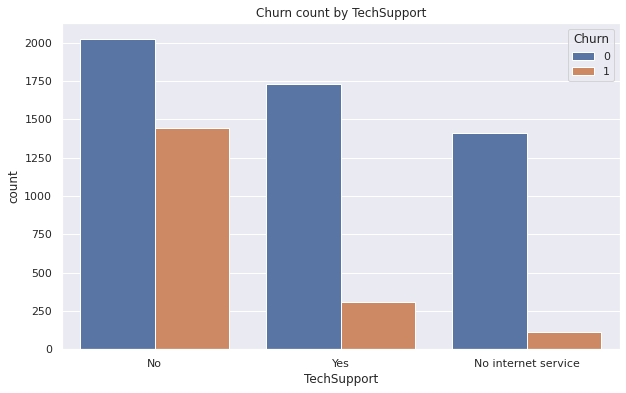

In [ ]:
Churn_by_feature_countplot(df, cat_features[14])

Churn                           0       1   Ratio(%)
PaymentMethod                                       
Bank transfer (automatic)  1286.0   258.0  16.709845
Credit card (automatic)    1290.0   232.0  15.243101
Electronic check           1294.0  1071.0  45.285412
Mailed check               1304.0   308.0  19.106700

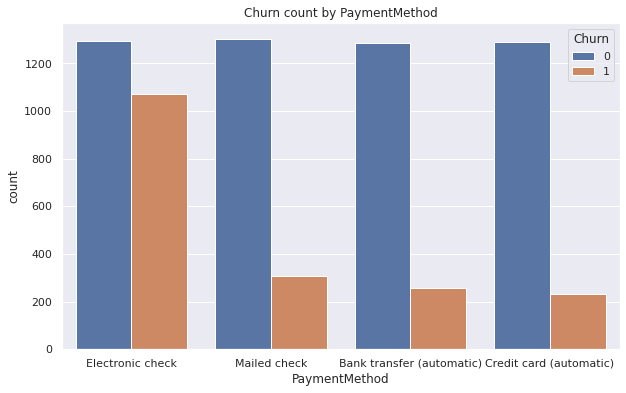

In [ ]:
Churn_by_feature_countplot(df, cat_features[12])

Churn                  0       1   Ratio(%)
PaperlessBilling                           
No                2403.0   469.0  16.330084
Yes               2771.0  1400.0  33.565092

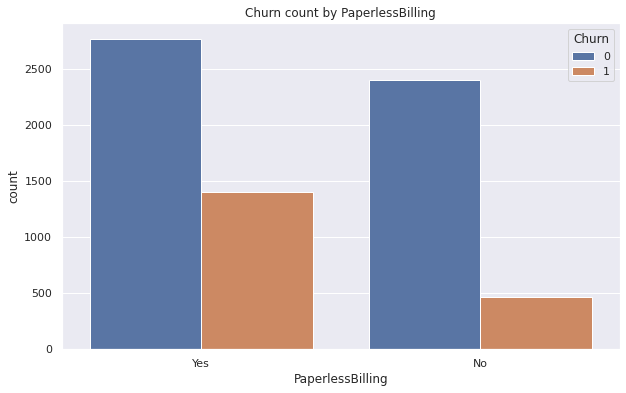

In [ ]:
Churn_by_feature_countplot(df, cat_features[13])

Churn                     0       1   Ratio(%)
DeviceProtection                              
No                   1884.0  1211.0  39.127625
No internet service  1413.0   113.0   7.404980
Yes                  1877.0   545.0  22.502064

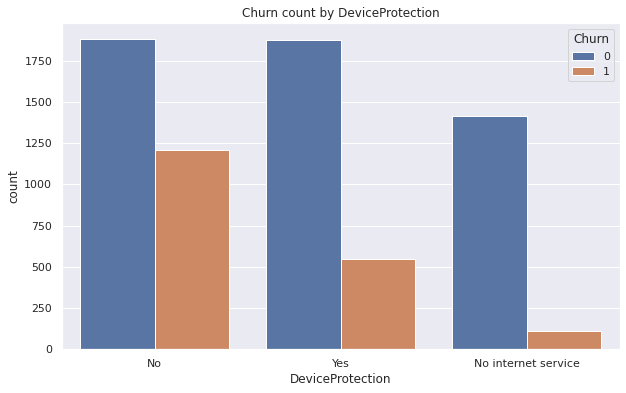

In [ ]:
Churn_by_feature_countplot(df, cat_features[15])

## 5. 상관관계 파악

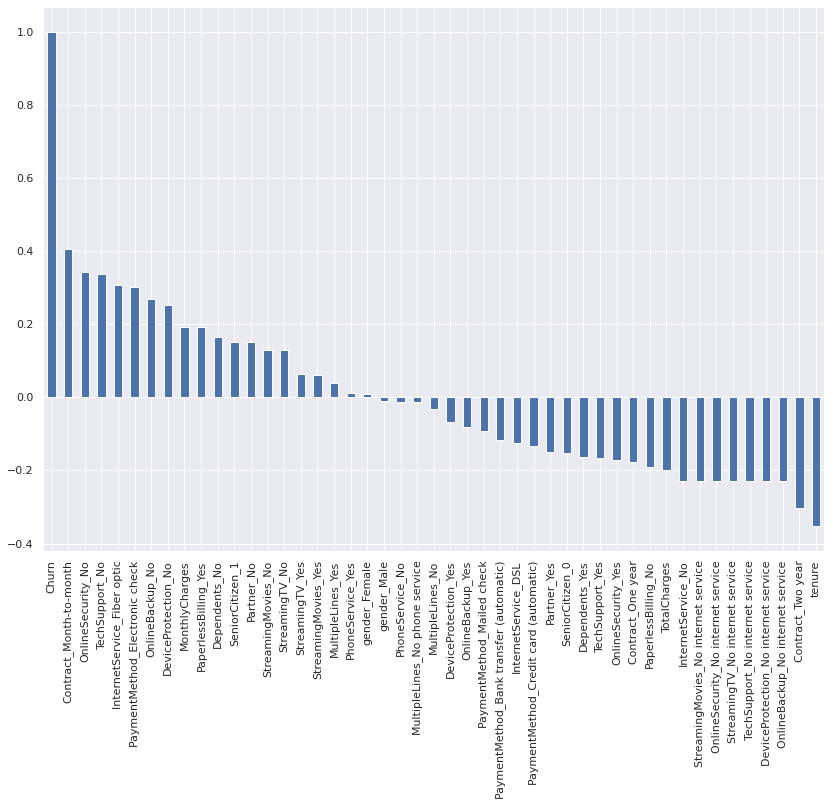

In [ ]:
# target과 feature들의 상관관계 파악하기
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))
(pd.get_dummies(df).corr()['Churn']).sort_values(ascending=False).plot(kind='bar');

- 왼쪽을 보면 어떤 요인의 어떤 카테고리가 고객의 이탈 확률을 높이는지 확인할 수 있다.
- 가운데에 있는 `PhoneService`, `gender`, `MultipleLines`는 고객 이탈률에 영향이 미미할 것으로 보인다. 그러나 Tree model에서는 제거해주지 않고 모델링을 진행한다.

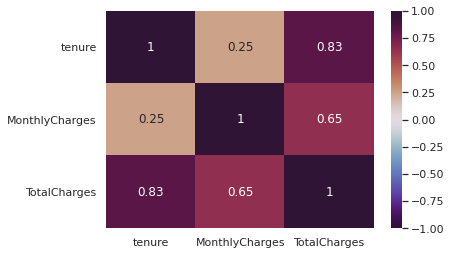

In [ ]:
ax = sns.heatmap(df[num_features].corr(), cmap='twilight_shifted', vmin=-1, vmax=1, annot=True)


- `tenure`과 `TotalCharges`의 상관관계는 0.83, `MonthlyCharges`와 `TotalCharges`의 상관관계는 0.65로 상관관계가 있다고 할 수 있으나 0.85가 넘지 않으므로 둘 다 삭제하지 않는다.

---


# Feature Engineering

## 1. 새로운 특성 만들기

1. `tenure`, `MonthlyChargers`로 고객 등급 나누기 

In [ ]:
# s_score 특성 만들기: tenure, MonthlyCharges로 등급 나누기
# log transformation
df['tenure_trsd'] = np.log(df['tenure'])
df['MonthlyCharges_trsd'] = np.log(df['MonthlyCharges'])

# EDA의 상관관계에서 tenure과 MonthlyCharges의 비율이 약 3:2이므로 이를 반영하여 점수를 계산한다
df['s_score'] = 0.6 * df['tenure_trsd'] + 0.4 * df['MonthlyCharges_trsd']

# 5개의 등급으로 나눈다
df['s_grade'] = pd.qcut(df['s_score'], 5, labels=['E', 'D', 'C', 'B', 'A']).astype(str)

# 필요 없는 칼럼 없애기
df.drop(['tenure_trsd', 'MonthlyCharges_trsd', 's_score'], axis=1, inplace=True)

Churn         0      1   Ratio(%)
s_grade                          
A        1232.0  177.0  12.562101
B        1123.0  285.0  20.241477
C        1124.0  285.0  20.227111
D         972.0  436.0  30.965909
E         723.0  686.0  48.687012

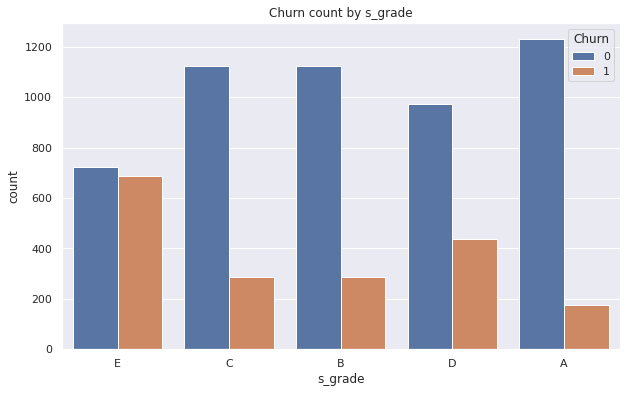

In [ ]:
Churn_by_feature_countplot(df, 's_grade')

- 등급이 낮을수록 이탈 확률이 높다.

2.  이용하는 부가 서비스 수에 따른 이탈 여부와 분석

In [ ]:
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df['UsingService'] = 0

for col in cols:
    for i in range(len(df)):
        if df[col][i] == 'Yes':
            df['UsingService'][i] = df['UsingService'][i] + 1

Churn              0      1   Ratio(%)
UsingService                          
0             1744.0  475.0  21.406039
1              524.0  442.0  45.755694
2              663.0  370.0  35.818006
3              812.0  306.0  27.370304
4              662.0  190.0  22.300469
5              500.0   71.0  12.434326
6              269.0   15.0   5.281690

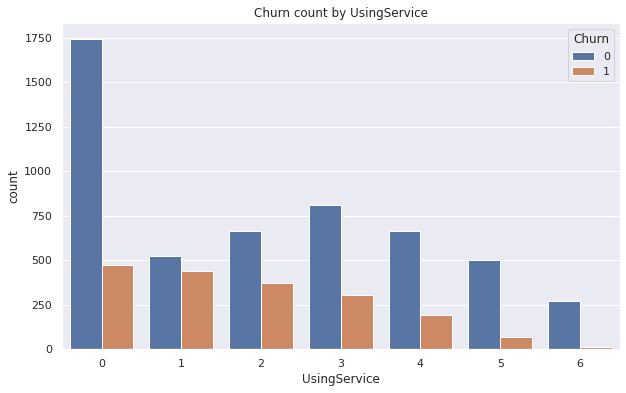

In [ ]:
Churn_by_feature_countplot(df, 'UsingService')

- 부가 서비스를 한 개만 이용하는 고객의 해지율이 가장 높다.

In [ ]:
# 이탈한 고객 중 부가서비스를 한 개만 이용하는 고객
df_oneService = df[(df['UsingService'] == 1) & (df['Churn'] == 1)]

In [ ]:
df_oneService_churn = pd.DataFrame(df_oneService[cols] == 'Yes').astype(int).sum(axis=0)
df_oneService_churn

OnlineSecurity       52
OnlineBackup         82
DeviceProtection     56
TechSupport          27
StreamingTV         105
StreamingMovies     120
dtype: int64

In [ ]:
# chi-shquare test
import scipy.stats as stats
stats.chisquare(df_oneService_churn, axis=None)

Power_divergenceResult(statistic=83.5837104072398, pvalue=1.4911510311877418e-16)

- 이탈한 고객 중 부가서비스를 하나만 이용한 고객들이 가장 많이 이용한 부가 서비스는 `StreamingMovies`이다. (차이가 통계적으로 유의함)

> `StreamingMovies`서비스가 고객들 붙잡을만한 메리트가 없는 건 아닌지 고민해봐야 한다.

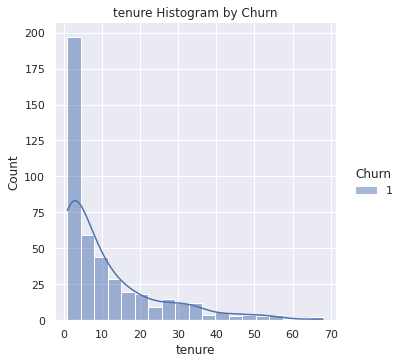

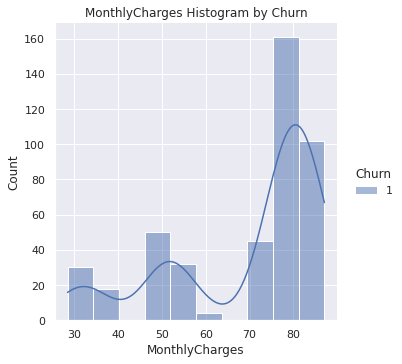

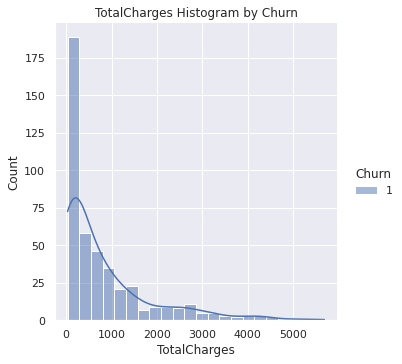

In [ ]:
sns.set_theme()
for s in num_features:
    ax = sns.displot(df_oneService, x=s, hue="Churn", kde=True);
    plt.title('{} Histogram by Churn'.format(s))

# Machine Learning Modeling

In [ ]:
# 데이터 분할과 인코딩을 위해 변수 유형 분류

    # target
target = 'Churn'

    # feature
features = df.columns.tolist()
features.remove(target)

    # 연속형 변수
numeric_features = ['TotalCharges', 'tenure', 'MonthlyCharges']

    # 순서형 변수
ordinal_features = ['s_grade']

    # 이진 변수
binary_features = [col for col in df.columns if df[col].nunique() == 2]
binary_features.remove(target)

    # 이진 변수가 아닌 범주형 변수
multicat_features = list(set(features).difference(numeric_features).difference(binary_features).difference(ordinal_features))

In [ ]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=10)

train = pd.concat([X_train, y_train], axis=1)

X_train, X_val, y_train, y_val = train_test_split(train[features], train[target], test_size=0.2, random_state=10)

train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test])

In [ ]:
from sklearn.metrics import classification_report

def testset_ClassificationReport(model, X_test):
    y_pred_test = model.predict(X_test)
    return print(classification_report(y_test, y_pred_test))

def valset_ClassificationReport(model, X_val):
    y_pred_val = model.predict(X_val)
    return print(classification_report(y_val, y_pred_val))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def testset_roc_auc_score(model, X_test):
    y_pred_proba = model.predict_proba(X_test)[:, -1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.scatter(fpr, tpr, color='blue')
    plt.plot(fpr, tpr, color='green')
    plt.title('ROC curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    return print('AUC score: ', roc_auc_score(y_test, y_pred_proba))

## 0. Baseline Model

In [ ]:
train[target].value_counts(normalize=True)

0    0.723097
1    0.276903
Name: Churn, dtype: float64

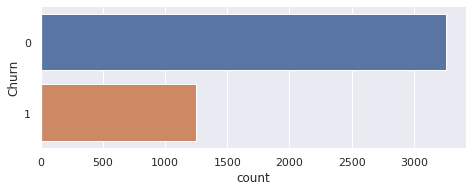

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme()
sns.catplot(y=train[target],  data = train, kind='count', height=2.6, aspect=2.5, orient='h');

- **기준 모델은 최빈 클래스인 0, 성능(Accuracy)은 최빈 클래스의 비율인 0.72이다.**

In [ ]:
scale_pos_weight = train[target].value_counts()[0] / train[target].value_counts()[1]
scale_pos_weight

2.6113782051282053

## 1. Random Forest

1. 기본 모델링

In [ ]:
from category_encoders import OrdinalEncoder

pipe_rf = make_pipeline(
    OrdinalEncoder(cols=sum([multicat_features, ordinal_features, binary_features],[]),
                   mapping = [{'col':'OnlineSecurity','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'Contract','mapping':{'Month-to-month':1, 'One year':2, 'Two year':3}},
                              {'col':'DeviceProtection','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'TechSupport','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'StreamingMovies','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'MultipleLines','mapping':{'No phone service':1, 'No':2, 'Yes':3}},
                              {'col':'InternetService','mapping':{'No':1, 'DSL':2, 'Fiber optic':3}},
                              {'col':'OnlineBackup','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'StreamingTV','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'PaymentMethod','mapping':{'Mailed check':1, 'Electronic check':2, 'Bank transfer (automatic)':3,
                                                                'Credit card (automatic)':4}},
                              {'col':'s_grade','mapping':{'A':1, 'B':2, 'C':3, 'D':4, 'E':5}},
                              {'col':'gender','mapping':{'Female':1, 'Male':2}},
                              {'col':'SeniorCitizen','mapping':{0:2, 1:1}},
                              {'col':'Partner','mapping':{'No':2, 'Yes':1}},
                              {'col':'Dependents','mapping':{'No':2, 'Yes':1}},
                              {'col':'PhoneService','mapping':{'No':2, 'Yes':1}},
                              {'col':'PaperlessBilling','mapping':{'No':2, 'Yes':1}},
                              ]
                   ),
    RandomForestClassifier(n_jobs=-1, random_state=10)
)

pipe_rf.fit(X_train, y_train);

In [ ]:
# 검증 데이터셋에서의 성능
valset_ClassificationReport(pipe_rf, X_val)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       849
           1       0.58      0.52      0.55       278

    accuracy                           0.79      1127
   macro avg       0.71      0.70      0.70      1127
weighted avg       0.78      0.79      0.78      1127



2. 모델 최적화

In [ ]:
# 최적의 하이퍼 파라미터 탐색
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

def hyperParameterTuning_RF(X_train, y_train):
    param_tuning = {
    'randomforestclassifier__class_weight' : ['balanced',scale_pos_weight],
    'randomforestclassifier__n_estimators': [10, 15, 50, 100],
    'randomforestclassifier__max_depth': [1, 5, 10, 15],
    'randomforestclassifier__min_samples_leaf' : [8, 12, 18],
    'randomforestclassifier__min_samples_split' : [8, 16, 20],
    'randomforestclassifier__max_features': [0.3, 0.5, 0.7] # max_features
    }

    pipe_rf = make_pipeline(
        OrdinalEncoder(cols=sum([multicat_features, ordinal_features, binary_features],[]),
                    mapping = [{'col':'OnlineSecurity','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'Contract','mapping':{'Month-to-month':1, 'One year':2, 'Two year':3}},
                                {'col':'DeviceProtection','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'TechSupport','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'StreamingMovies','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'MultipleLines','mapping':{'No phone service':1, 'No':2, 'Yes':3}},
                                {'col':'InternetService','mapping':{'No':1, 'DSL':2, 'Fiber optic':3}},
                                {'col':'OnlineBackup','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'StreamingTV','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'PaymentMethod','mapping':{'Mailed check':1, 'Electronic check':2, 'Bank transfer (automatic)':3,
                                                                    'Credit card (automatic)':4}},
                                {'col':'s_grade','mapping':{'A':1, 'B':2, 'C':3, 'D':4, 'E':5}},
                                {'col':'gender','mapping':{'Female':1, 'Male':2}},
                                {'col':'SeniorCitizen','mapping':{0:2, 1:1}},
                                {'col':'Partner','mapping':{'No':2, 'Yes':1}},
                                {'col':'Dependents','mapping':{'No':2, 'Yes':1}},
                                {'col':'PhoneService','mapping':{'No':2, 'Yes':1}},
                                {'col':'PaperlessBilling','mapping':{'No':2, 'Yes':1}},
                                ]
                    ),
        RandomForestClassifier(n_jobs=-1, random_state=10)
    )

    gsearch = GridSearchCV(estimator = pipe_rf,
                           param_grid = param_tuning,                        
                           scoring = 'roc_auc',
                           cv = 3,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

hyperParameterTuning_RF(X_train, y_train)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed:  4.2min finished


{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__max_features': 0.3,
 'randomforestclassifier__min_samples_leaf': 18,
 'randomforestclassifier__min_samples_split': 8,
 'randomforestclassifier__n_estimators': 100}

```
{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__max_features': 0.3,
 'randomforestclassifier__min_samples_leaf': 18,
 'randomforestclassifier__min_samples_split': 8,
 'randomforestclassifier__n_estimators': 100}
 ```

In [ ]:
# 리모델링
pipe_rf_rmd = make_pipeline(
    OrdinalEncoder(cols=sum([multicat_features, ordinal_features, binary_features],[]),
                   mapping = [{'col':'OnlineSecurity','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'Contract','mapping':{'Month-to-month':1, 'One year':2, 'Two year':3}},
                              {'col':'DeviceProtection','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'TechSupport','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'StreamingMovies','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'MultipleLines','mapping':{'No phone service':1, 'No':2, 'Yes':3}},
                                {'col':'InternetService','mapping':{'No':1, 'DSL':2, 'Fiber optic':3}},
                                {'col':'OnlineBackup','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'StreamingTV','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'PaymentMethod','mapping':{'Mailed check':1, 'Electronic check':2, 'Bank transfer (automatic)':3,
                                                                    'Credit card (automatic)':4}},
                                {'col':'s_grade','mapping':{'A':1, 'B':2, 'C':3, 'D':4, 'E':5}},
                                {'col':'gender','mapping':{'Female':1, 'Male':2}},
                                {'col':'SeniorCitizen','mapping':{0:2, 1:1}},
                                {'col':'Partner','mapping':{'No':2, 'Yes':1}},
                                {'col':'Dependents','mapping':{'No':2, 'Yes':1}},
                                {'col':'PhoneService','mapping':{'No':2, 'Yes':1}},
                                {'col':'PaperlessBilling','mapping':{'No':2, 'Yes':1}},
                                ]
                    ),
        RandomForestClassifier(n_jobs=-1,
                               class_weight='balanced',
                               max_depth=10,
                               max_features=0.3,
                               min_samples_leaf=18,
                               min_samples_split=8,
                               n_estimators=100,
                               random_state=10)
    )

pipe_rf_rmd.fit(X_train, y_train);

In [ ]:
# 성능 개선 확인
valset_ClassificationReport(pipe_rf_rmd, X_val)

              precision    recall  f1-score   support

           0       0.91      0.75      0.82       849
           1       0.51      0.78      0.61       278

    accuracy                           0.76      1127
   macro avg       0.71      0.76      0.72      1127
weighted avg       0.81      0.76      0.77      1127



In [ ]:
# 테스트셋에서의 성능 확인
testset_ClassificationReport(pipe_rf_rmd, X_test)

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1066
           1       0.51      0.75      0.61       343

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.81      0.76      0.78      1409



AUC score:  0.8430483155470712


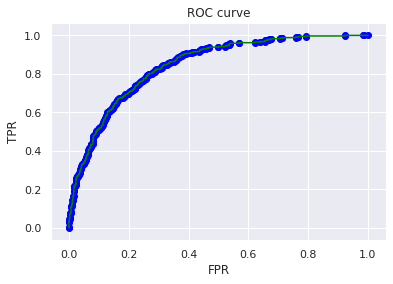

In [ ]:
testset_roc_auc_score(pipe_rf_rmd, X_test)

## 2. xgboost Model

1. 기본 모델링

In [ ]:
pipe_xgb = make_pipeline(
    OrdinalEncoder(cols=sum([multicat_features, ordinal_features, binary_features],[]),
                   mapping = [{'col':'OnlineSecurity','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'Contract','mapping':{'Month-to-month':1, 'One year':2, 'Two year':3}},
                              {'col':'DeviceProtection','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'TechSupport','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'StreamingMovies','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'MultipleLines','mapping':{'No phone service':1, 'No':2, 'Yes':3}},
                              {'col':'InternetService','mapping':{'No':1, 'DSL':2, 'Fiber optic':3}},
                              {'col':'OnlineBackup','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'StreamingTV','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'PaymentMethod','mapping':{'Mailed check':1, 'Electronic check':2, 'Bank transfer (automatic)':3,
                                                                'Credit card (automatic)':4}},
                              {'col':'s_grade','mapping':{'A':1, 'B':2, 'C':3, 'D':4, 'E':5}},
                              {'col':'gender','mapping':{'Female':1, 'Male':2}},
                              {'col':'SeniorCitizen','mapping':{0:2, 1:1}},
                              {'col':'Partner','mapping':{'No':2, 'Yes':1}},
                              {'col':'Dependents','mapping':{'No':2, 'Yes':1}},
                              {'col':'PhoneService','mapping':{'No':2, 'Yes':1}},
                              {'col':'PaperlessBilling','mapping':{'No':2, 'Yes':1}},
                              ]
                   ),
    XGBClassifier(random_state=10)
)

pipe_xgb.fit(X_train, y_train);

In [ ]:
# 검증 데이터셋에서의 성능
valset_ClassificationReport(pipe_xgb, X_val)

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       849
           1       0.60      0.53      0.56       278

    accuracy                           0.80      1127
   macro avg       0.72      0.71      0.71      1127
weighted avg       0.79      0.80      0.79      1127



-  xgboost가 기본적으로 더 안정적으로 모델링 한다.

2. 모델 최적화

In [ ]:
# 과적합 되지 않는 n_estimator 찾기
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

model = XGBClassifier(
    n_estimators=1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    learning_rate=0.2,
    scale_pos_weight=scale_pos_weight, # imbalance 데이터 일 경우 비율을 적용합니다.
    n_jobs=-1,
    random_state=10
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

[0]	validation_0-error:0.298868	validation_1-error:0.332742
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.298868	validation_1-error:0.332742
[2]	validation_0-error:0.265809	validation_1-error:0.287489
[3]	validation_0-error:0.254715	validation_1-error:0.274179
[4]	validation_0-error:0.253606	validation_1-error:0.274179
[5]	validation_0-error:0.252718	validation_1-error:0.263532
[6]	validation_0-error:0.252274	validation_1-error:0.263532
[7]	validation_0-error:0.250277	validation_1-error:0.263532
[8]	validation_0-error:0.243399	validation_1-error:0.254658
[9]	validation_0-error:0.245396	validation_1-error:0.264419
[10]	validation_0-error:0.243177	validation_1-error:0.25732
[11]	validation_0-error:0.243177	validation_1-error:0.259982
[12]	validation_0-error:0.242068	validation_1-error:0.259982
[13]	validation_0-error:0.239405	validation_1-error:0.255

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.6113782051282053,
              seed=None, silent=None, subsample=1, verbosity=1)

- 적당한 `n_estimator`은 19

In [ ]:
# XGBoost hyper-parameter tuning

def hyperParameterTuning_XGB(X_train, y_train):
    param_tuning = {
        'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
        'xgbclassifier__max_depth': [1, 2, 3, 5],
        'xgbclassifier__min_child_weight': [1, 2, 3, 5, 9],
        'xgbclassifier__n_estimators' : [15, 19, 50, 100],
        'xgbclassifier__scale_pos_weight' : [1, scale_pos_weight, 3]
    }

    pipe_xgb = make_pipeline(
        OrdinalEncoder(cols=sum([multicat_features, ordinal_features, binary_features],[]),
                    mapping = [{'col':'OnlineSecurity','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'Contract','mapping':{'Month-to-month':1, 'One year':2, 'Two year':3}},
                                {'col':'DeviceProtection','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'TechSupport','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'StreamingMovies','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'MultipleLines','mapping':{'No phone service':1, 'No':2, 'Yes':3}},
                                {'col':'InternetService','mapping':{'No':1, 'DSL':2, 'Fiber optic':3}},
                                {'col':'OnlineBackup','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'StreamingTV','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'PaymentMethod','mapping':{'Mailed check':1, 'Electronic check':2, 'Bank transfer (automatic)':3,
                                                                    'Credit card (automatic)':4}},
                                {'col':'s_grade','mapping':{'A':1, 'B':2, 'C':3, 'D':4, 'E':5}},
                                {'col':'gender','mapping':{'Female':1, 'Male':2}},
                                {'col':'SeniorCitizen','mapping':{0:2, 1:1}},
                                {'col':'Partner','mapping':{'No':2, 'Yes':1}},
                                {'col':'Dependents','mapping':{'No':2, 'Yes':1}},
                                {'col':'PhoneService','mapping':{'No':2, 'Yes':1}},
                                {'col':'PaperlessBilling','mapping':{'No':2, 'Yes':1}},
                                ]
                    ),
        XGBClassifier(learning_rate=0.01,
                    n_estimators=142,
                    scale_pos_weight=scale_pos_weight)
    )

    gsearch = GridSearchCV(estimator = pipe_xgb,
                           param_grid = param_tuning,                        
                           scoring = 'roc_auc',
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

hyperParameterTuning_XGB(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  6.2min finished


{'xgbclassifier__learning_rate': 0.2,
 'xgbclassifier__max_depth': 1,
 'xgbclassifier__min_child_weight': 9,
 'xgbclassifier__n_estimators': 100,
 'xgbclassifier__scale_pos_weight': 1}

```
{'xgbclassifier__learning_rate': 0.2,
 'xgbclassifier__max_depth': 1,
 'xgbclassifier__min_child_weight': 9,
 'xgbclassifier__n_estimators': 100,
 'xgbclassifier__scale_pos_weight': 1}
```

In [ ]:
# 리모델링
pipe_xgb_rmd = make_pipeline(
    OrdinalEncoder(cols=sum([multicat_features, ordinal_features, binary_features],[]),
                   mapping = [{'col':'OnlineSecurity','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'Contract','mapping':{'Month-to-month':1, 'One year':2, 'Two year':3}},
                              {'col':'DeviceProtection','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'TechSupport','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'StreamingMovies','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'MultipleLines','mapping':{'No phone service':1, 'No':2, 'Yes':3}},
                              {'col':'InternetService','mapping':{'No':1, 'DSL':2, 'Fiber optic':3}},
                              {'col':'OnlineBackup','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'StreamingTV','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                              {'col':'PaymentMethod','mapping':{'Mailed check':1, 'Electronic check':2, 'Bank transfer (automatic)':3,
                                                                'Credit card (automatic)':4}},
                              {'col':'s_grade','mapping':{'A':1, 'B':2, 'C':3, 'D':4, 'E':5}},
                              {'col':'gender','mapping':{'Female':1, 'Male':2}},
                              {'col':'SeniorCitizen','mapping':{0:2, 1:1}},
                              {'col':'Partner','mapping':{'No':2, 'Yes':1}},
                              {'col':'Dependents','mapping':{'No':2, 'Yes':1}},
                              {'col':'PhoneService','mapping':{'No':2, 'Yes':1}},
                              {'col':'PaperlessBilling','mapping':{'No':2, 'Yes':1}},
                              ]
                   ),
    XGBClassifier(learning_rate=0.2,
                  max_depth=1,
                  min_child_weight=9,
                  n_estimators=100,
                  scale_pos_weight=1)
)

pipe_xgb_rmd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['DeviceProtection', 'UsingService',
                                      'OnlineBackup', 'PaymentMethod',
                                      'Contract', 'TechSupport', 'StreamingTV',
                                      'StreamingMovies', 'MultipleLines',
                                      'OnlineSecurity', 'InternetService',
                                      's_grade', 'gender', 'SeniorCitizen',
                                      'Partner', 'Dependents', 'PhoneService',
                                      'PaperlessBilling'],
                                drop_invariant=Fa...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.2,
                               max_delta_step=0, max_depth=1,
                        

In [ ]:
# 성능 개선 확인
valset_ClassificationReport(pipe_xgb_rmd, X_val)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       849
           1       0.59      0.54      0.56       278

    accuracy                           0.79      1127
   macro avg       0.72      0.71      0.71      1127
weighted avg       0.79      0.79      0.79      1127



In [ ]:
# 테스트셋에서의 성능 확인
testset_ClassificationReport(pipe_xgb_rmd, X_test)

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1066
           1       0.62      0.55      0.58       343

    accuracy                           0.81      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



AUC score:  0.844715264824772


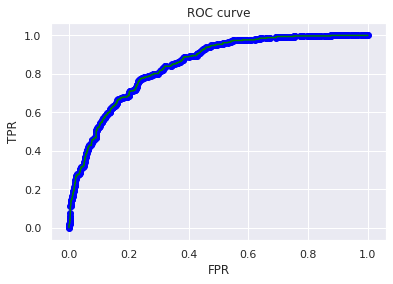

In [ ]:
testset_roc_auc_score(pipe_xgb_rmd, X_test)

## 3. Logistic Regression Model

In [ ]:
def engineering_for_Logistic(df):
    df_new = df.copy()
    # 연속형 변수들의 로그 log transformation
    # np.log를 사용하면 -inf값 생김 -> log1p사용
    df_new['tenure_trsd'] = np.log1p(df_new['tenure'])
    df_new['MonthlyCharges_trsd'] = np.log1p(df_new['MonthlyCharges'])
    df_new['TotalCharges_trsd'] = np.log1p(df_new['TotalCharges'])

    df_drd = df_new.drop(['tenure', 'MonthlyCharges', 'TotalCharges'], axis=1)

    # PhoneService, gender, MultipleLines 변수 제거(상관관계 참고)
    df_drd = df_drd.drop(['PhoneService', 'gender', 'MultipleLines'], axis=1)

    df_drd['SeniorCitizen'] = df_drd['SeniorCitizen'].astype(str)

    return df_drd

X_train_trsd = engineering_for_Logistic(X_train)
X_val_trsd = engineering_for_Logistic(X_val)
X_test_trsd = engineering_for_Logistic(X_test)

1. 기본 모델링

In [ ]:
pipe_lgr = make_pipeline(
    OrdinalEncoder(cols=['s_grade'],
                   mapping=[{'col':'s_grade','mapping':{'A':1, 'B':2, 'C':3, 'D':4, 'E':5}}]
                   ),
    OneHotEncoder(use_cat_names = True),
    LogisticRegressionCV(random_state=10,
                       max_iter=1000)
)

pipe_lgr.fit(X_train_trsd, y_train);

In [ ]:
# 검증 데이터셋에서의 성능
valset_ClassificationReport(pipe_lgr, X_val_trsd)

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       849
           1       0.59      0.52      0.55       278

    accuracy                           0.79      1127
   macro avg       0.72      0.70      0.71      1127
weighted avg       0.79      0.79      0.79      1127



2. 모델 최적화

In [ ]:
# 하이퍼 파라미터 튜닝
pipe_lgr_rmd = make_pipeline(
    OrdinalEncoder(cols=['s_grade'],
                   mapping=[{'col':'s_grade','mapping':{'A':1, 'B':2, 'C':3, 'D':4, 'E':5}}]
                   ),
    OneHotEncoder(use_cat_names = True),
    LogisticRegressionCV(random_state=10,
                         scoring = 'roc_auc',
                         cv=3,
                         Cs=27,
                         max_iter=1000,
                         class_weight=scale_pos_weight)
)

pipe_lgr_rmd.fit(X_train_trsd, y_train);

In [ ]:
# 성능 개선 확인
valset_ClassificationReport(pipe_lgr_rmd, X_val_trsd)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       849
           1       0.58      0.53      0.56       278

    accuracy                           0.79      1127
   macro avg       0.72      0.70      0.71      1127
weighted avg       0.79      0.79      0.79      1127



In [ ]:
# 테스트셋에서의 성능 확인
testset_ClassificationReport(pipe_lgr_rmd, X_test_trsd)

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1066
           1       0.62      0.53      0.57       343

    accuracy                           0.81      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.80      0.81      0.80      1409



AUC score:  0.8438168352304738


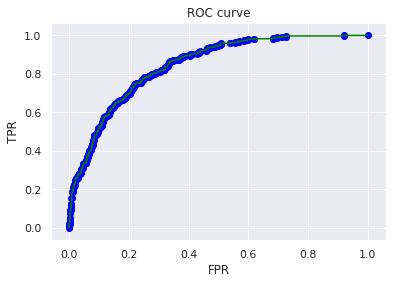

In [ ]:
testset_roc_auc_score(pipe_lgr_rmd, X_test_trsd)

- 하이퍼 파라미터 값을 조정해봐도 별 차이가 없으나, 조정한 모델이 아주 약간 더 좋다.

## 4. 모델 비교 및 성능 평가

- Random Forest

In [ ]:
testset_ClassificationReport(pipe_rf_rmd, X_test)

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1066
           1       0.51      0.75      0.61       343

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.81      0.76      0.78      1409



AUC score:  0.8430483155470712


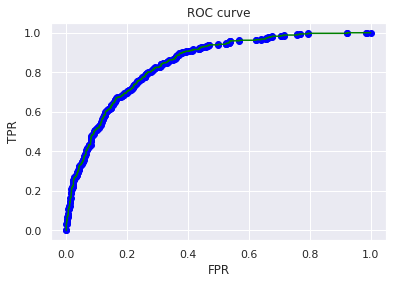

In [ ]:
testset_roc_auc_score(pipe_rf_rmd, X_test)

- xgboost

In [ ]:
testset_ClassificationReport(pipe_xgb_rmd, X_test)

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1066
           1       0.62      0.55      0.58       343

    accuracy                           0.81      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



AUC score:  0.844715264824772


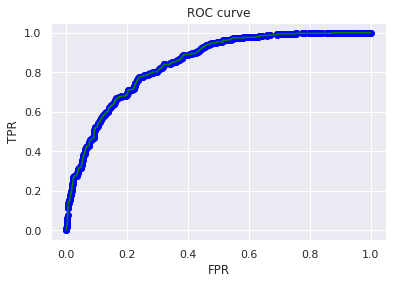

In [ ]:
testset_roc_auc_score(pipe_xgb_rmd, X_test)

- Logistic Regression

In [ ]:
testset_ClassificationReport(pipe_lgr_rmd, X_test_trsd)

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1066
           1       0.62      0.53      0.57       343

    accuracy                           0.81      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.80      0.81      0.80      1409



AUC score:  0.8438168352304738


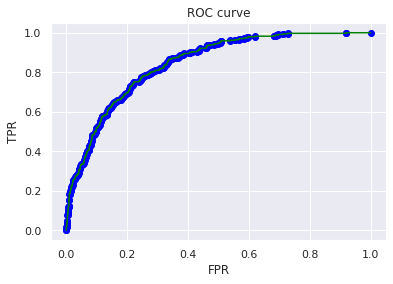

In [ ]:
testset_roc_auc_score(pipe_lgr_rmd, X_test_trsd)

- 전체적인 성능은 xgboost와 Logistic Regression 모델이 더 좋으나, 치명적인 오류인 FN을 고려하는 recall값이 다른 두 모델에 비해 낮다.

- Accuracy는 가장 낮지만 기준모델보다는 높고 recall score가 보장되어있으므로 Random Forest 모델의 성능이 더 좋다고 할 수 있다.

> ***Random Forest 모델을 최종 모델로 선정한다.***


#### 이 모델의 한계

- 약 5%의 Accuracy 저하를 감안하고 이 모델을 선택했을 때 정확히 얼마만큼의 비용이 절감되는지 알 수 없다.

> 따라서 실제로 필드에 적용할 모델을 만들 때에는 **고객 유지 비용과 와 고객 유치 비용의 손익 분기점**을 고려해서 recall값의 가중치를 조절할 수 있는 *f beta score*에 중점을 두고 모델을 만들어야 한다.

## Permutation Importance로 feature selection

- 필요한 feature들만 남겨서 다시 모델링한다.

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe_rf_rmd.named_steps['randomforestclassifier'], # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=10
)

# permuter 계산은 preprocessing 된 X_val을 사용
X_val_encoded = pipe_rf_rmd.named_steps['ordinalencoder'].transform(X_val)

permuter.fit(X_val_encoded, y_val);

In [ ]:
# 특성별 score 확인
feature_names = X_val_encoded.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

- 중요도가 음수인 특성은 제거해준다.

In [ ]:
print('특성 삭제 전:', X_train.shape, X_val.shape)

특성 삭제 전: (4507, 21) (1127, 21)


In [ ]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
selected_features = X_train.columns[mask]
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

In [ ]:
print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape)

특성 삭제 후: (4507, 9) (1127, 9)


In [ ]:
selected_num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
selected_cat_features = ['Contract','InternetService','StreamingTV', 'StreamingMovies', 'PaymentMethod', 's_grade']

In [ ]:
# 특성 삭제 후 리모델링
pipe_rf_rmd2 = make_pipeline(
    OrdinalEncoder(cols=selected_cat_features,
                   mapping = [{'col':'Contract','mapping':{'Month-to-month':1, 'One year':2, 'Two year':3}},
                              {'col':'StreamingMovies','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'InternetService','mapping':{'No':1, 'DSL':2, 'Fiber optic':3}},
                                {'col':'StreamingTV','mapping':{'No internet service':1, 'No':2, 'Yes':3}},
                                {'col':'PaymentMethod','mapping':{'Mailed check':1, 'Electronic check':2, 'Bank transfer (automatic)':3,
                                                                    'Credit card (automatic)':4}},
                                {'col':'s_grade','mapping':{'A':1, 'B':2, 'C':3, 'D':4, 'E':5}},
                                ]
                    ),
        RandomForestClassifier(n_jobs=-1,
                               class_weight='balanced',
                               max_depth=10,
                               max_features=0.3,
                               min_samples_leaf=18,
                               min_samples_split=8,
                               n_estimators=100,
                               random_state=10)
    )

pipe_rf_rmd2.fit(X_train_selected, y_train);

## 최종 모델의 성능

In [ ]:
testset_ClassificationReport(pipe_rf_rmd2, X_test_selected)

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1066
           1       0.51      0.76      0.61       343

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.81      0.76      0.77      1409



AUC score:  0.8404501173291616


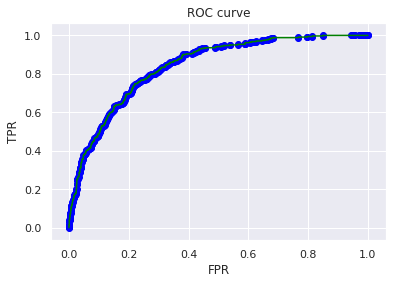

In [ ]:
testset_roc_auc_score(pipe_rf_rmd2, X_test_selected)

# Interpreting ML Model

## 1. Permutation Importance 확인하기

In [ ]:
# permuter 정의
permuter2 = PermutationImportance(
    pipe_rf_rmd2.named_steps['randomforestclassifier'], # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=10
)

# permuter 계산은 preprocessing 된 X_val을 사용
X_val_encoded2 = pipe_rf_rmd2.named_steps['ordinalencoder'].transform(X_val_selected)

permuter2.fit(X_val_encoded2, y_val);

In [ ]:
# 특성별 score 확인
feature_names2 = X_val_encoded2.columns.tolist()

eli5.show_weights(
    permuter2, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names2 # list 형식으로 넣어야 합니다
)

## 2. PDP (1 feature)

In [ ]:
rf = pipe_rf_rmd2.named_steps['randomforestclassifier']
X_val_encoded = pipe_rf_rmd2.named_steps['ordinalencoder'].transform(X_val_selected)
X_test_encoded = pipe_rf_rmd2.named_steps['ordinalencoder'].transform(X_test_selected)
X_train_encoded = pipe_rf_rmd2.named_steps['ordinalencoder'].transform(X_train_selected)

### Positive 영향

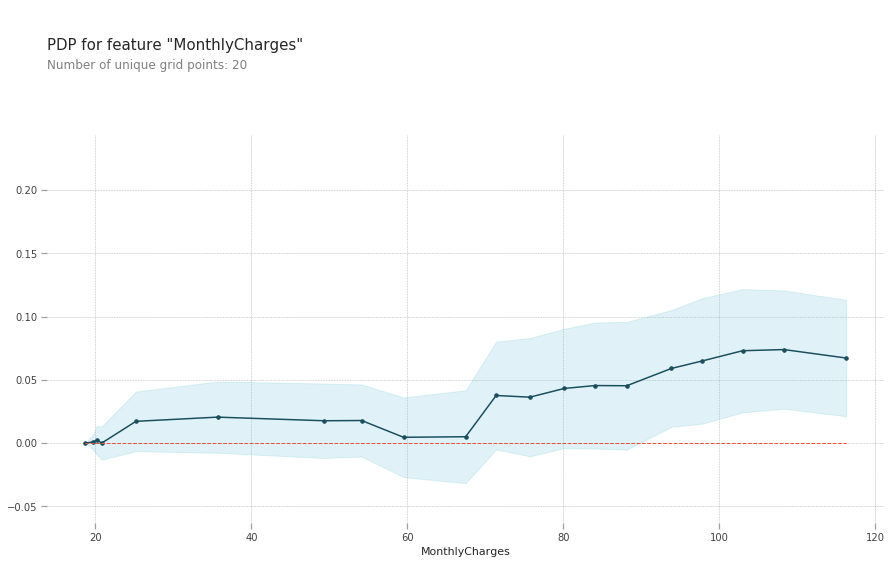

In [ ]:
isolated = pdp_isolate(
    model=pipe_rf_rmd2, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns,
    feature='MonthlyCharges',
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=20 # default=10
)
pdp_plot(isolated, feature_name='MonthlyCharges');

- 월 요금의 중간 부분은 안정적인 데에 비해 약 70보다 많이 내는 사람의 이탈확률은 올라간다.

- 이 통신사의 요금제를 파악하고 이 차트를 보면 더 다양한 해석을 할 수 있을 것이다.

    예시)

    1. 특정 요금의 서비스에 문제가 있을 수 있다. (경사가 급하게 올라가는 부분)
    2. 부가 서비스 이용에 따라 월 납부 요금이 올라갔고, 그에 따른 이탈 확률이 올라갔다. → 부가 서비스 제공에 문제가 있다.

In [ ]:
feature = 'InternetService'
for item in pipe_rf_rmd2.named_steps['ordinalencoder'].mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
category_names = list(feature_mapping.keys())
category_codes = list(feature_mapping.values())

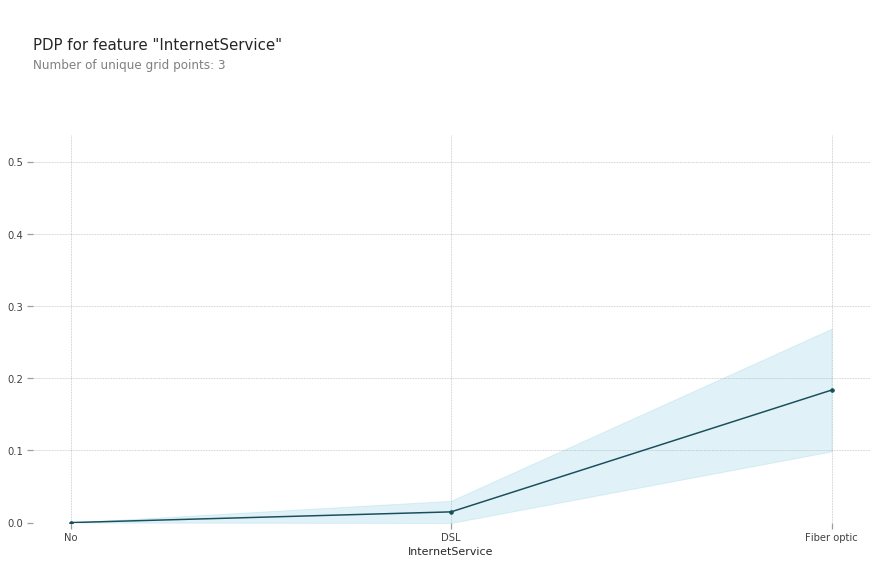

In [ ]:
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val_encoded, model_features=X_val_encoded.columns, feature='InternetService')

pdp.pdp_plot(pdp_dist, 'InternetService');
plt.xticks(category_codes, category_names);

In [ ]:
feature = 's_grade'
for item in pipe_rf_rmd2.named_steps['ordinalencoder'].mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
category_names = list(feature_mapping.keys())
category_codes = list(feature_mapping.values())

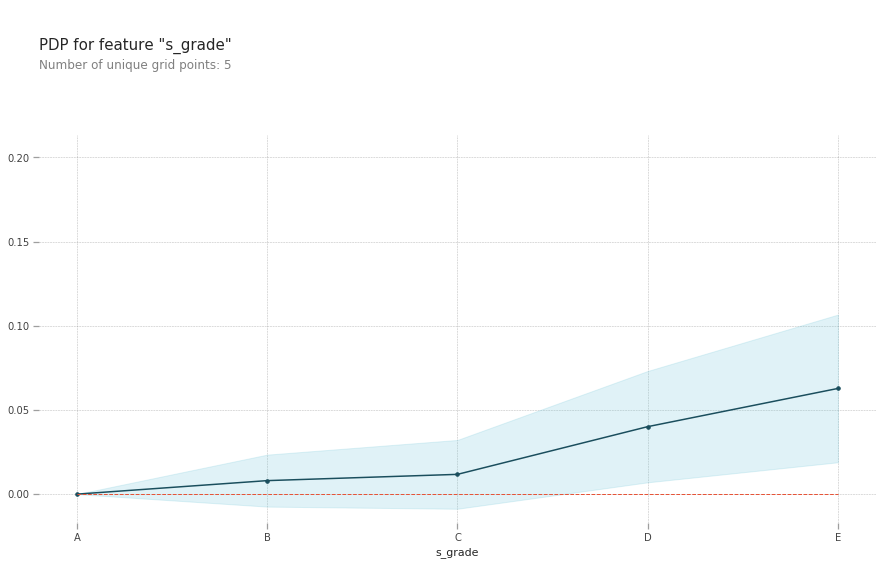

In [ ]:
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val_encoded, model_features=X_val_encoded.columns, feature='s_grade')

pdp.pdp_plot(pdp_dist, 's_grade');
plt.xticks(category_codes, category_names);

In [ ]:
feature = 'PaymentMethod'
for item in pipe_rf_rmd2.named_steps['ordinalencoder'].mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
category_names = list(feature_mapping.keys())
category_codes = list(feature_mapping.values())

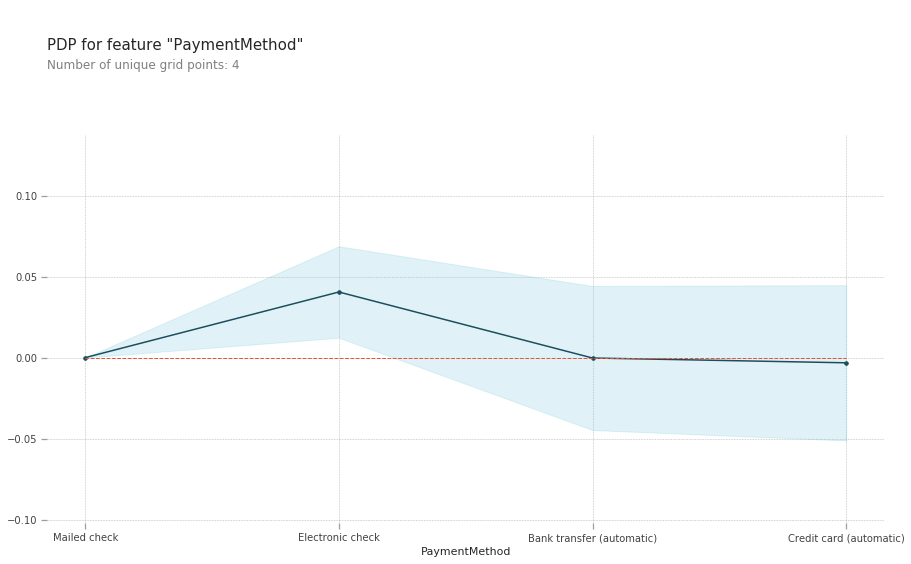

In [ ]:
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val_encoded, model_features=X_val_encoded.columns, feature='PaymentMethod')

pdp.pdp_plot(pdp_dist, 'PaymentMethod');
plt.xticks(category_codes, category_names);

In [ ]:
feature = 'StreamingMovies'
for item in pipe_rf_rmd2.named_steps['ordinalencoder'].mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
category_names = list(feature_mapping.keys())
category_codes = list(feature_mapping.values())

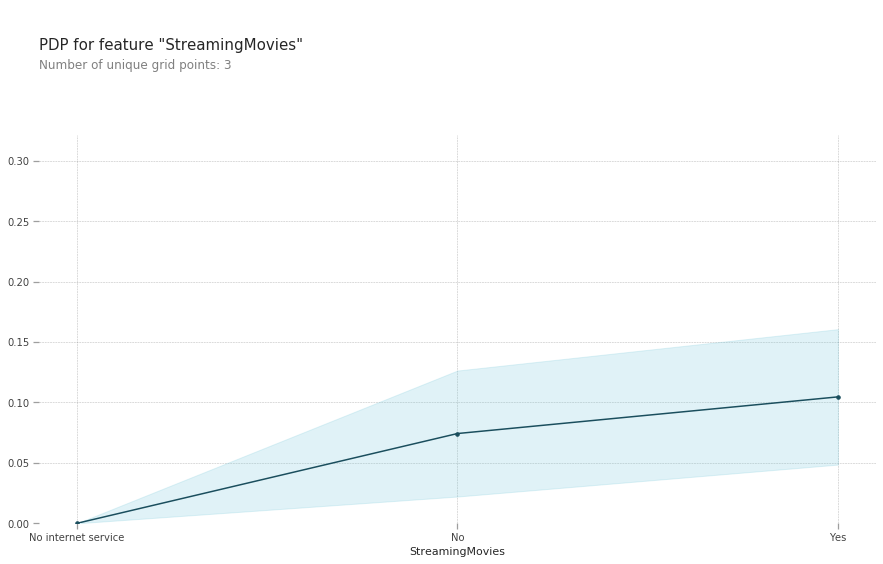

In [ ]:
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val_encoded, model_features=X_val_encoded.columns, feature='StreamingMovies')

pdp.pdp_plot(pdp_dist, 'StreamingMovies');
plt.xticks(category_codes, category_names);

In [ ]:
feature = 'StreamingTV'
for item in pipe_rf_rmd2.named_steps['ordinalencoder'].mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
category_names = list(feature_mapping.keys())
category_codes = list(feature_mapping.values())

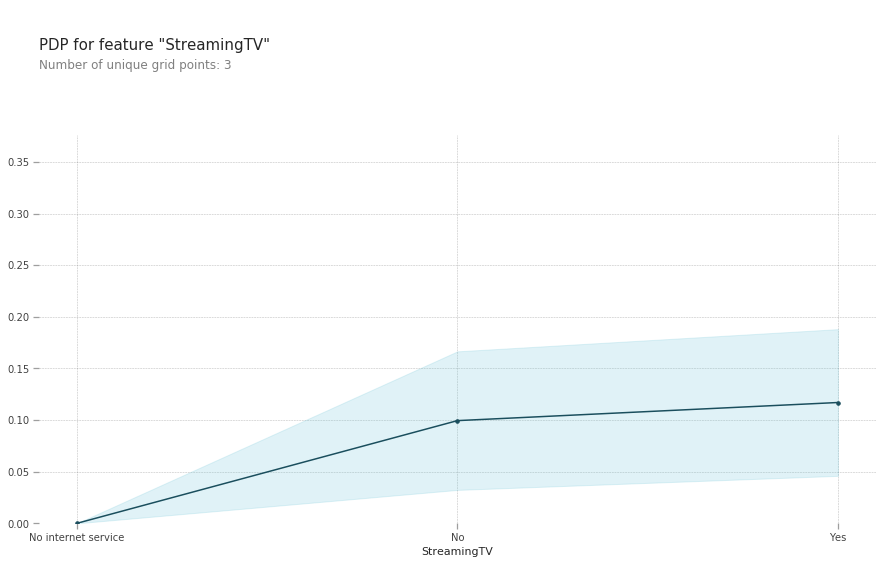

In [ ]:
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val_encoded, model_features=X_val_encoded.columns, feature='StreamingTV')

pdp.pdp_plot(pdp_dist, 'StreamingTV');
plt.xticks(category_codes, category_names);

- 부가서비스의 사용 여부가 대체적으로 이탈 확률에 + 영향을 미친다. → 서비스 개선이 필요하다.


### Negative 영향

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


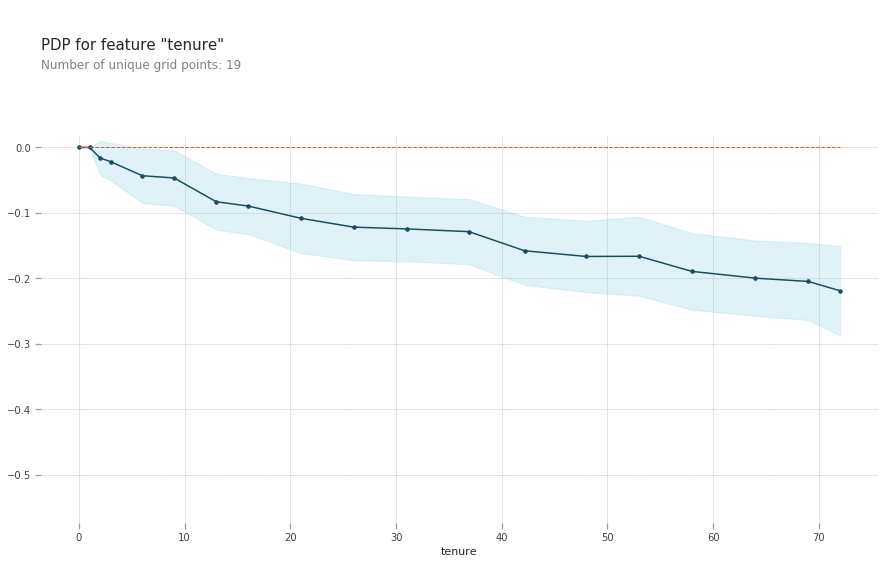

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

isolated = pdp_isolate(
    model=pipe_rf_rmd2, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns,
    feature='tenure',
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=20 # default=10
)
pdp_plot(isolated, feature_name='tenure');

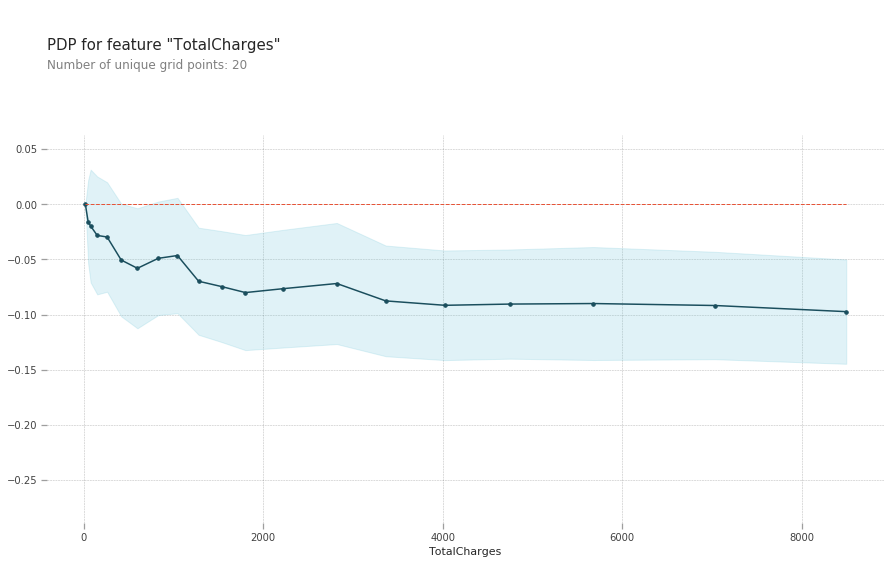

In [ ]:
isolated = pdp_isolate(
    model=pipe_rf_rmd2, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns,
    feature='TotalCharges',
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=20 # default=10
)
pdp_plot(isolated, feature_name='TotalCharges');

In [ ]:
# PDP 카테고리값 맵핑

feature = 'Contract'
for item in pipe_rf_rmd2.named_steps['ordinalencoder'].mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
category_names = list(feature_mapping.keys())
category_codes = list(feature_mapping.values())

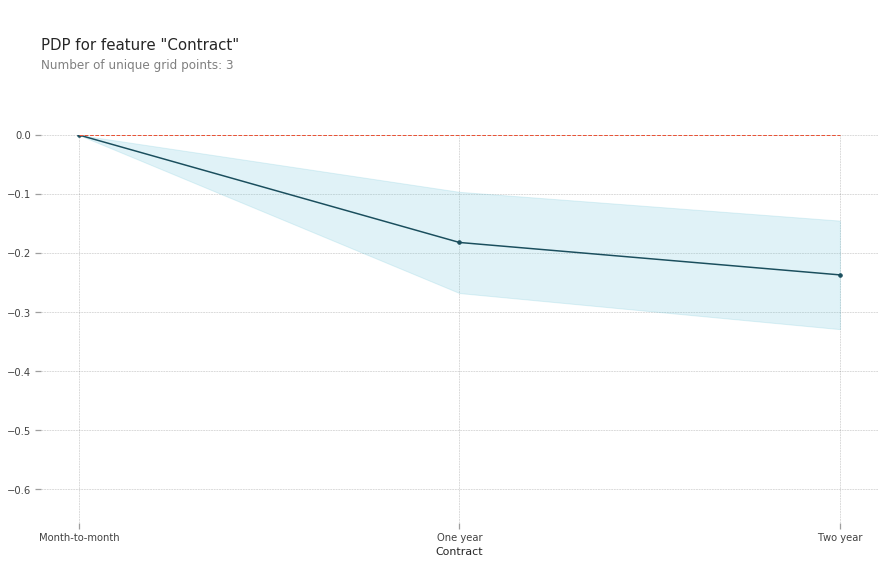

In [ ]:
from pdpbox import pdp
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_val_encoded, model_features=X_val_encoded.columns, feature='Contract')

pdp.pdp_plot(pdp_dist, 'Contract');
plt.xticks(category_codes, category_names);

- 세 특성 모두 '가입 기간'에 관련된 feature로, 장기 고객일수록 이탈 확률이 더 적어진다. → 장기 고객 확보의 중요성(Lock in 효과)

## PDP (2 features)

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [ ]:
def pdp_2features(feature1, feature2):
    interaction = pdp_interact(
        model=rf, 
        dataset=X_val_encoded,
        model_features=X_val_encoded.columns,  
        features=[feature1, feature2]
    )
    pdp_interact_plot(interaction, plot_type='grid',
                  feature_names=[feature1, feature2]);

### 1. 스트리밍 서비스 & MonthlyCharges

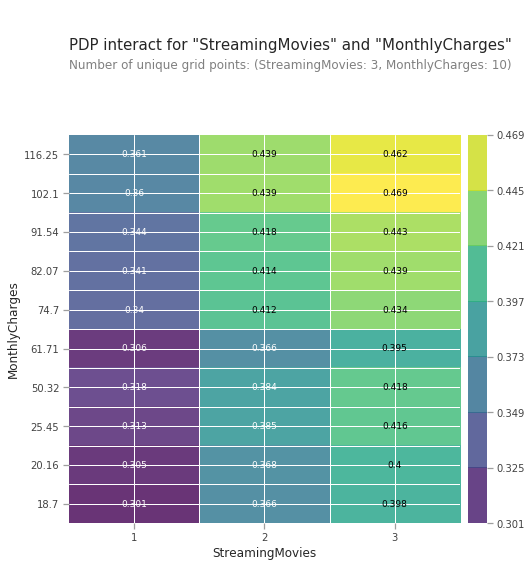

In [ ]:
pdp_2features('StreamingMovies', 'MonthlyCharges')

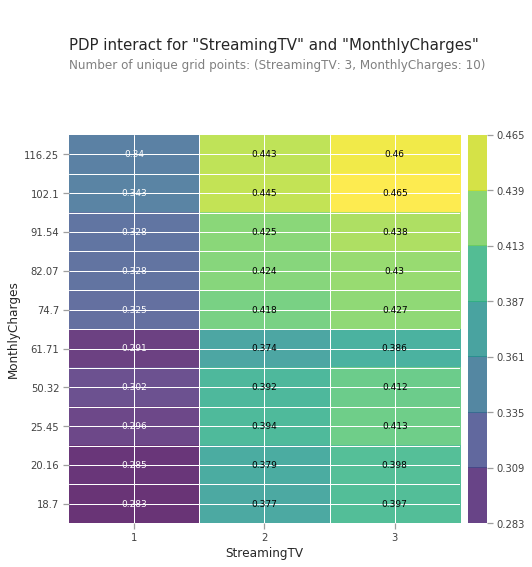

In [ ]:
pdp_2features('StreamingTV', 'MonthlyCharges')

- 스트리밍 서비스와 월 납부 요금 두 가지 요인에 따라 이탈 확률이 달라지므로, **스트리밍 서비스의 이용 여부가 월 납부 요금이 올라감에 따라 이탈 확률이 올라가는 원인 중 하나**로 볼 수 있다.

### 2. InternetService & tenure

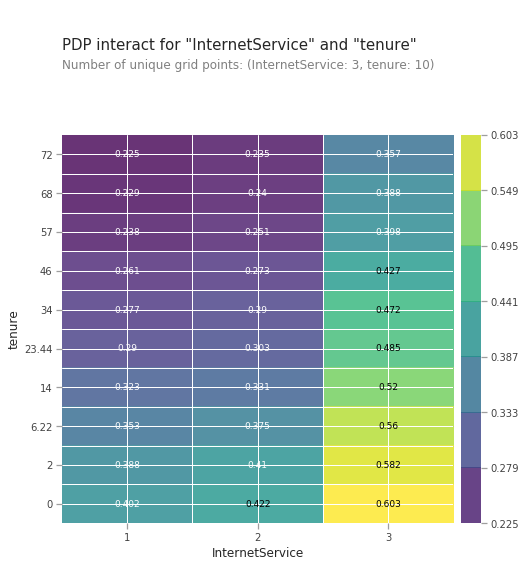

In [ ]:
pdp_2features('InternetService', 'tenure')

- 다른 요인의 조합보다 이 두 조합의 고객 이탈 확률이 가장 높다.

- 가입하지 얼마 되지 않은 고객이 'Fiber optic' 인터넷 서비스를 사용했을 때 이탈 확률이 가장 높아지므로 반드시 Fiver optic의 문제를 파악하고 해결할 필요가 있다.

### 3. 다른 features

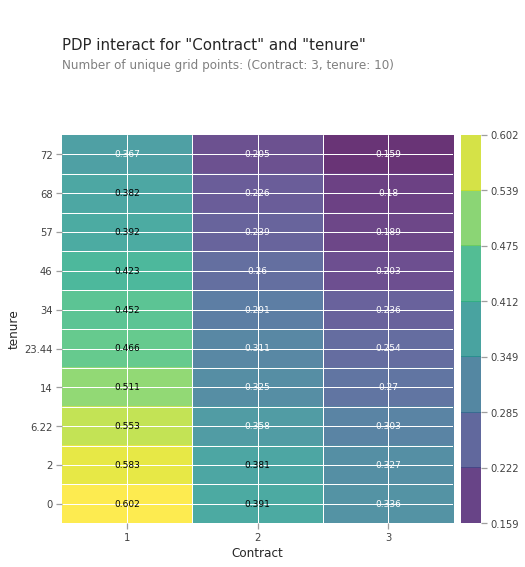

In [ ]:
pdp_2features('Contract', 'tenure')

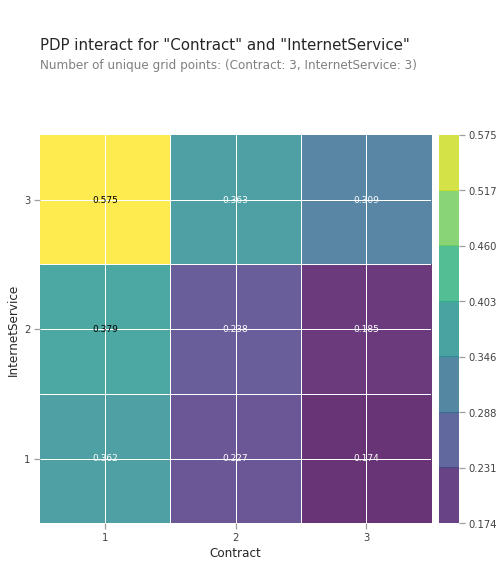

In [ ]:
pdp_2features('Contract', 'InternetService')

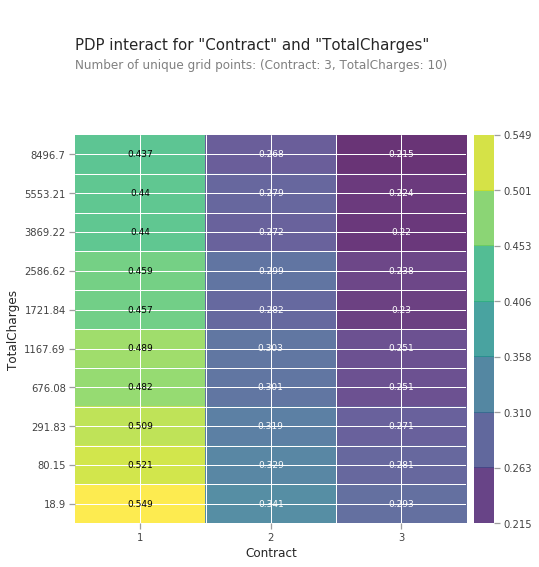

In [ ]:
pdp_2features('Contract', 'TotalCharges')

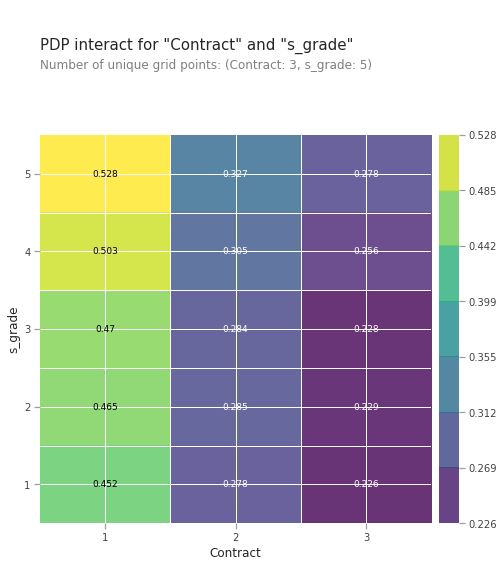

In [ ]:
pdp_2features('Contract', 's_grade')

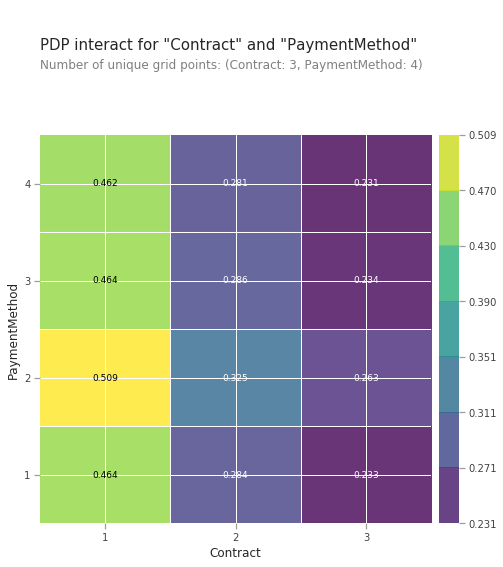

In [ ]:
pdp_2features('Contract', 'PaymentMethod')

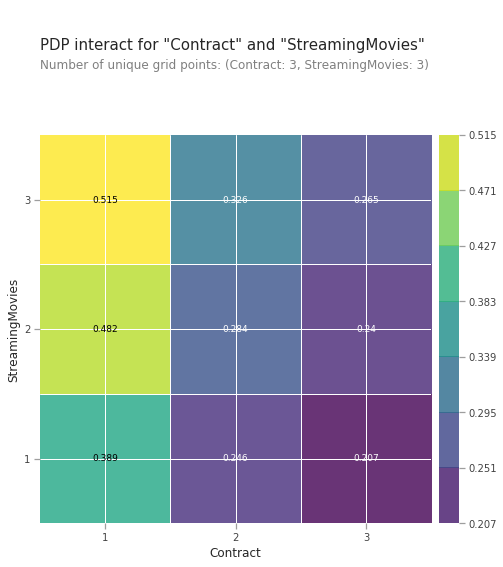

In [ ]:
pdp_2features('Contract', 'StreamingMovies')

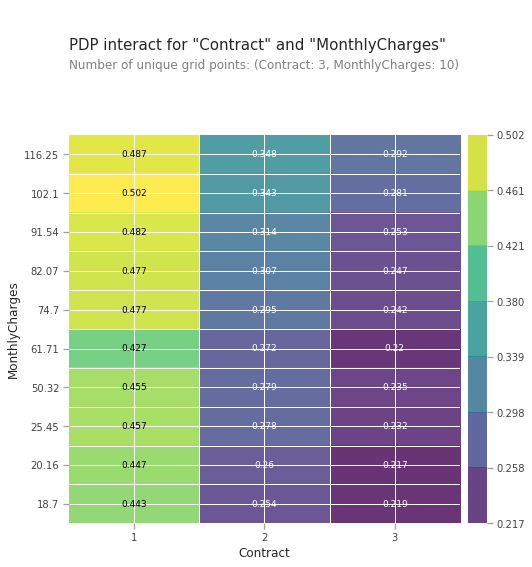

In [ ]:
pdp_2features('Contract', 'MonthlyCharges')

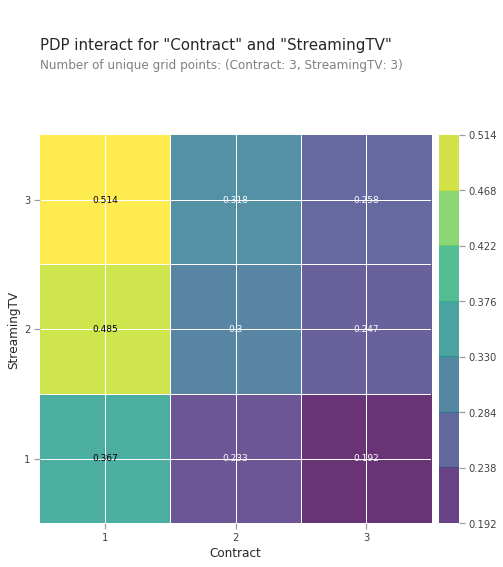

In [ ]:
pdp_2features('Contract', 'StreamingTV')

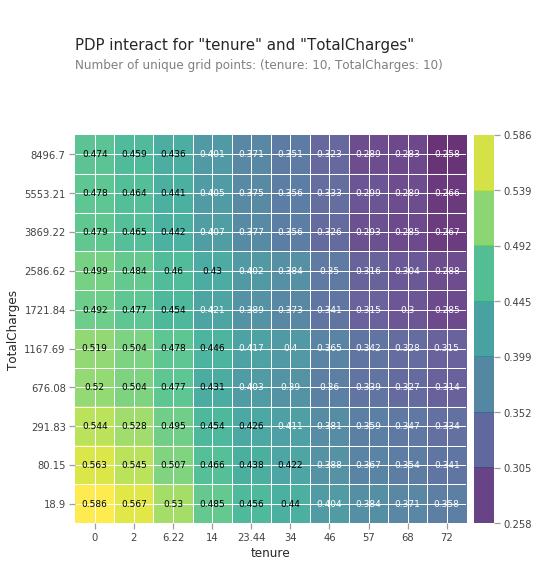

In [ ]:
pdp_2features('tenure', 'TotalCharges')

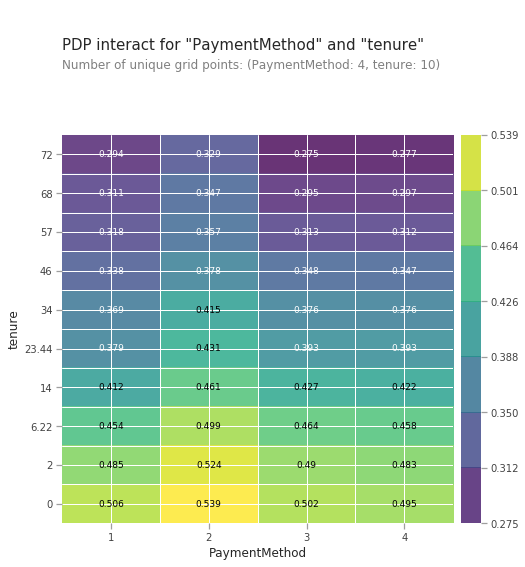

In [ ]:
pdp_2features('PaymentMethod', 'tenure')

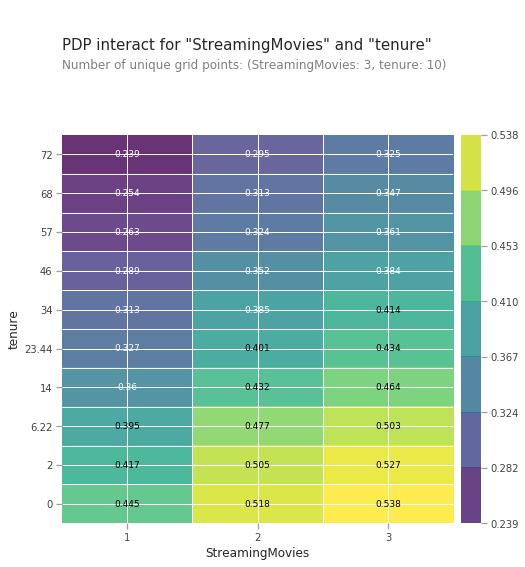

In [ ]:
pdp_2features('StreamingMovies', 'tenure')

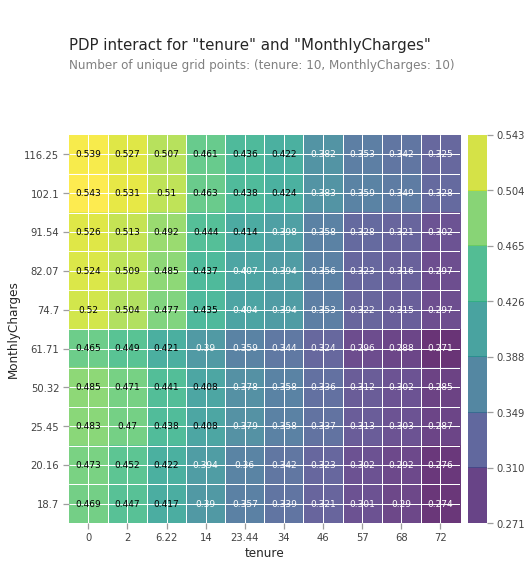

In [ ]:
pdp_2features('tenure', 'MonthlyCharges')

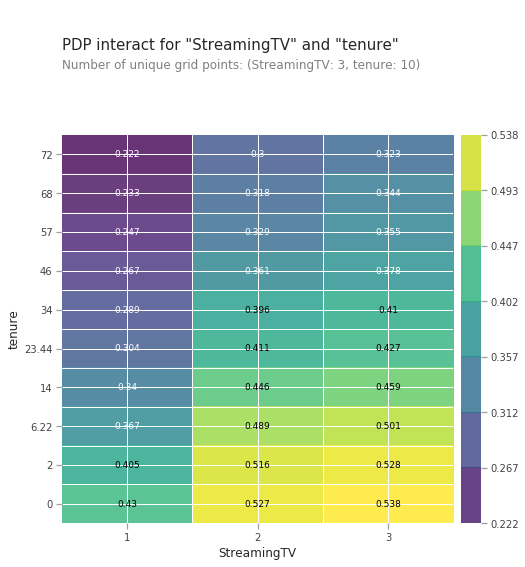

In [ ]:
pdp_2features('StreamingTV', 'tenure')

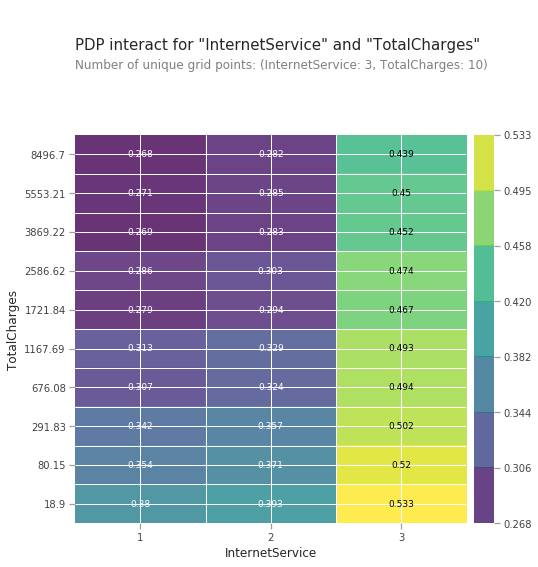

In [ ]:
pdp_2features('InternetService', 'TotalCharges')

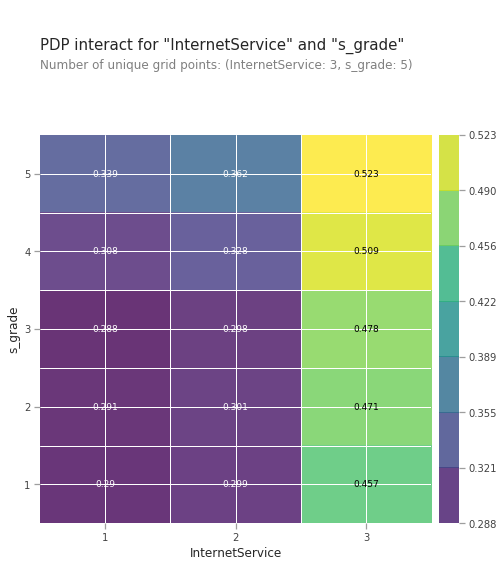

In [ ]:
pdp_2features('InternetService', 's_grade')

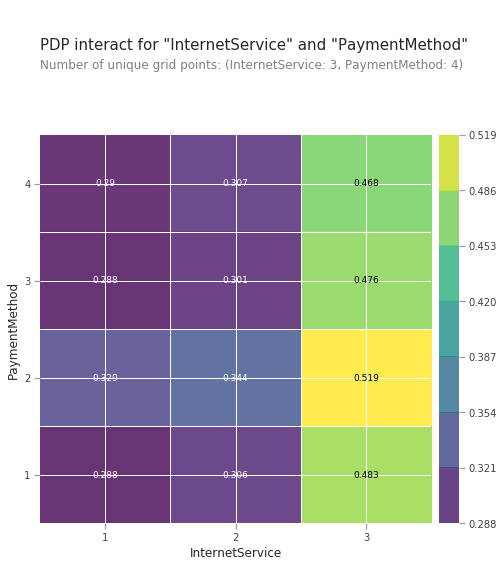

In [ ]:
pdp_2features('InternetService', 'PaymentMethod')

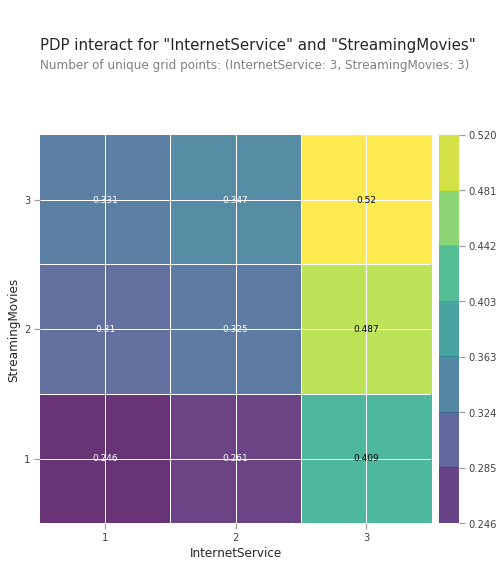

In [ ]:
pdp_2features('InternetService', 'StreamingMovies')

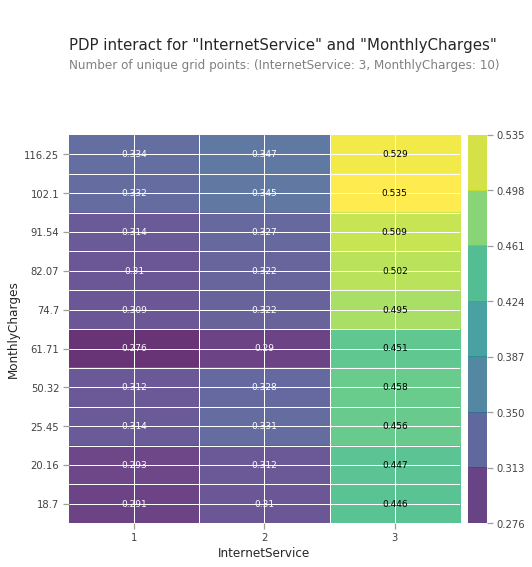

In [ ]:
pdp_2features('InternetService', 'MonthlyCharges')

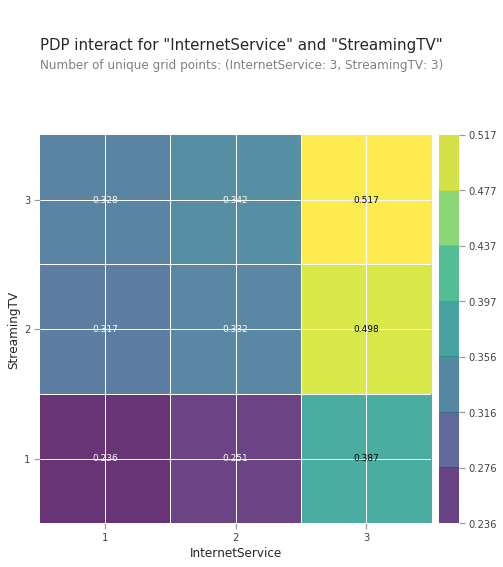

In [ ]:
pdp_2features('InternetService', 'StreamingTV')

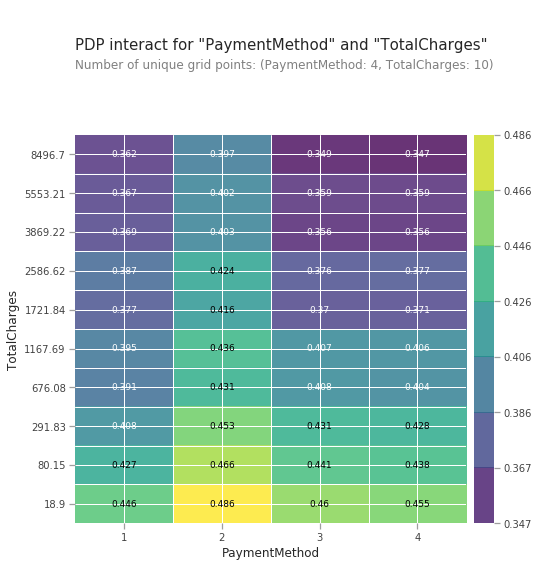

In [ ]:
pdp_2features('PaymentMethod', 'TotalCharges')

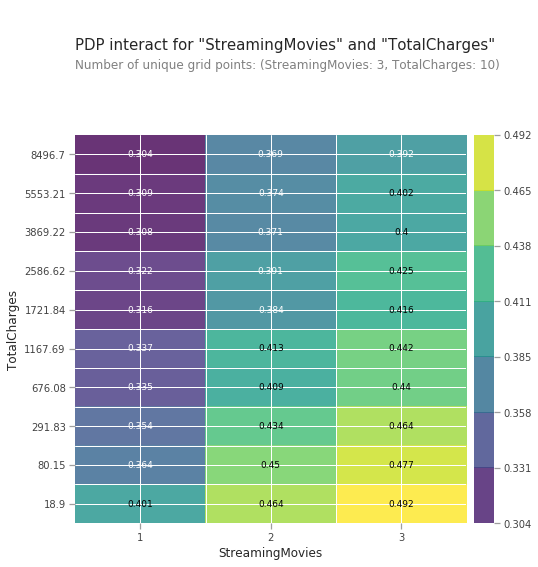

In [ ]:
pdp_2features('StreamingMovies', 'TotalCharges')

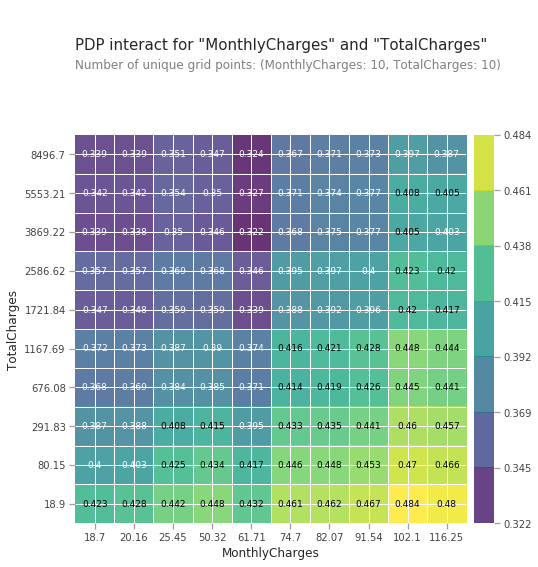

In [ ]:
pdp_2features('MonthlyCharges', 'TotalCharges')

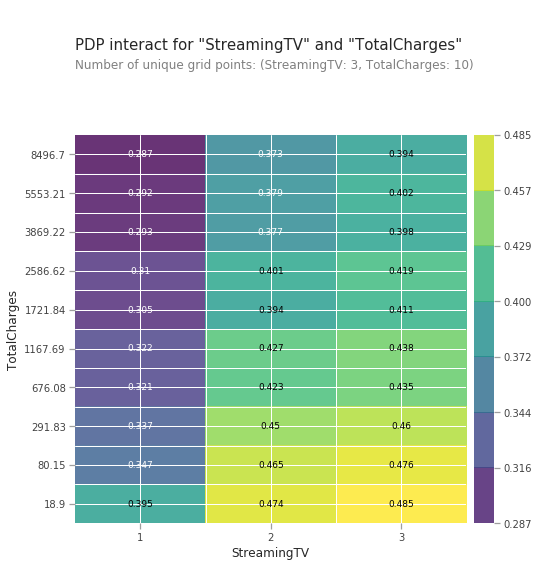

In [ ]:
pdp_2features('StreamingTV', 'TotalCharges')

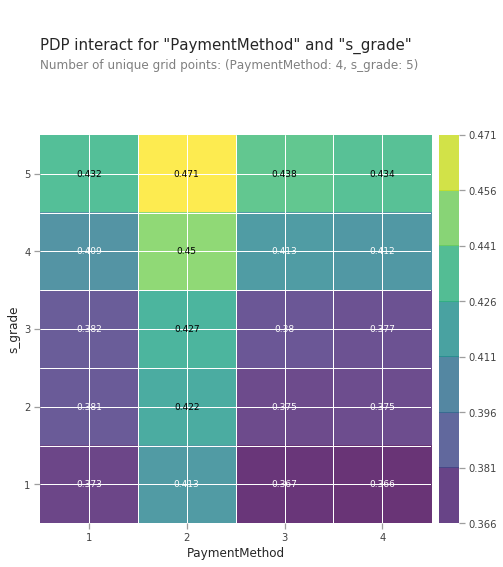

In [ ]:
pdp_2features('PaymentMethod', 's_grade')

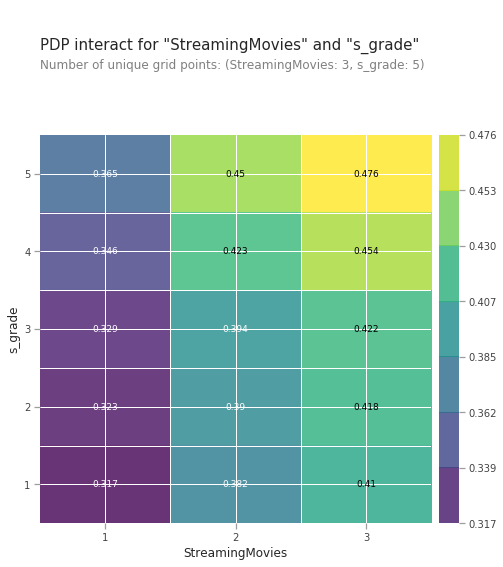

In [ ]:
pdp_2features('StreamingMovies', 's_grade')

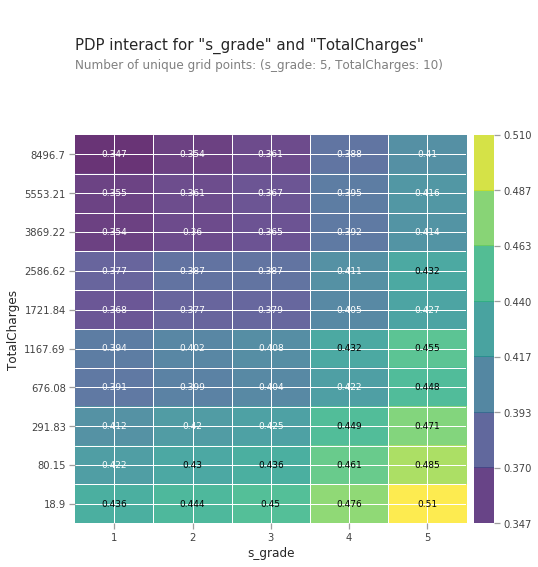

In [ ]:
pdp_2features('s_grade', 'TotalCharges')

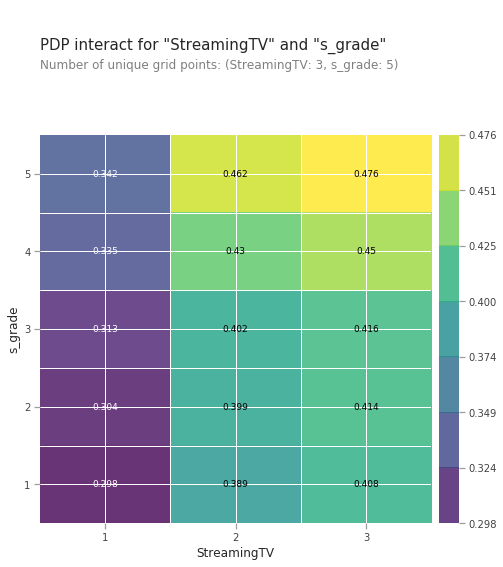

In [ ]:
pdp_2features('StreamingTV', 's_grade')

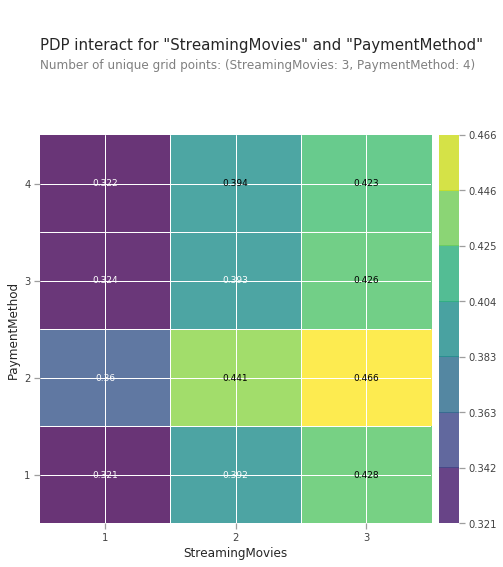

In [ ]:
pdp_2features('StreamingMovies', 'PaymentMethod')

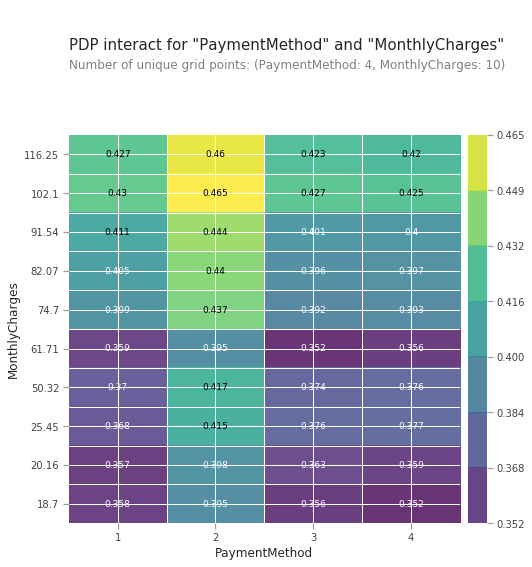

In [ ]:
pdp_2features('PaymentMethod', 'MonthlyCharges')

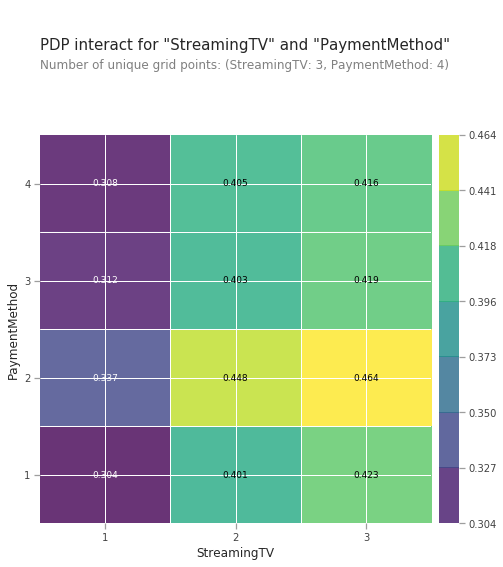

In [ ]:
pdp_2features('StreamingTV', 'PaymentMethod')

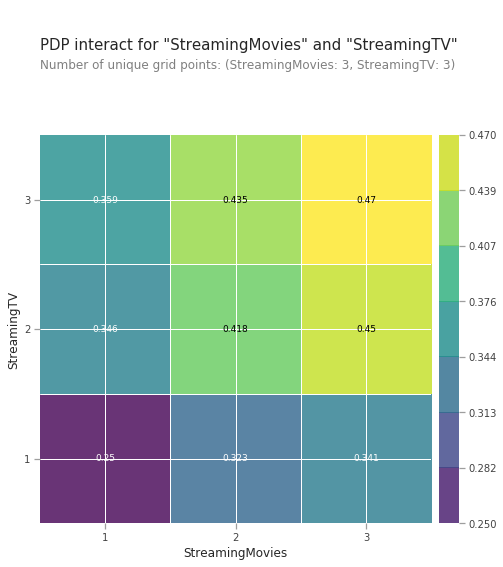

In [ ]:
pdp_2features('StreamingMovies', 'StreamingTV')

## 3. SHAP

- Force Plot

In [ ]:
row = X_test_selected.iloc[[50]]
row

tenure InternetService StreamingTV  ... MonthlyCharges TotalCharges s_grade
4081       1     Fiber optic          No  ...           69.6         69.6       E

[1 rows x 9 columns]

In [ ]:
import shap

explainer = shap.TreeExplainer(rf)
X_val_encoded_row = pipe_rf_rmd2.named_steps['ordinalencoder'].transform(row)
shap_values = explainer.shap_values(X_val_encoded_row)

shap.initjs()
shap.force_plot(
    # [1] = positive class
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1][0], 
    features=X_val_encoded_row
)

- Force plot 사용자 지정 함수 만들기

In [ ]:
y_pred_proba = pipe_rf_rmd2.predict_proba(X_test_selected)[:,1]

df_p = pd.DataFrame({
    'pred_proba': y_pred_proba, # 예측확률 
    'status_group': y_test # 실제값
}).reset_index()

In [ ]:
df_p = df_p.merge(
     df[X_train_selected.columns.tolist()].reset_index(),
     how='left'
)

In [ ]:
df_p.head()

index  pred_proba  status_group  ...  MonthlyCharges TotalCharges s_grade
0   6418    0.327470             0  ...           79.30      2484.00       B
1   1948    0.929357             1  ...           80.75       159.45       E
2   4497    0.351285             0  ...           97.95      5867.00       A
3     66    0.331112             0  ...           78.90      3650.35       B
4   1705    0.451285             0  ...           90.45      5044.80       A

[5 rows x 12 columns]

In [ ]:
churn_O = df_p['status_group'] == 1
churn_X = ~churn_O
right = (churn_O) == (df_p['pred_proba'] > 0.50)
wrong = ~right

In [ ]:
# 이탈한다는 예측이 맞는 경우
df_p[churn_O & right].sort_values(by='pred_proba')

index  pred_proba  status_group  ...  MonthlyCharges TotalCharges s_grade
585    3490    0.502276             1  ...           51.05       415.05       D
405    4721    0.507896             1  ...           20.25        20.25       E
324    1981    0.512559             1  ...          102.10      5885.40       A
38     2990    0.518581             1  ...           33.90       298.45       D
1233   1068    0.537226             1  ...           99.05      4853.75       A
...     ...         ...           ...  ...             ...          ...     ...
252    1879    0.963721             1  ...           70.05        70.05       E
923    4536    0.965729             1  ...           69.35        69.35       E
803    6488    0.965729             1  ...           69.50        69.50       E
1077   4463    0.966556             1  ...           69.85        69.85       E
50     4081    0.968848             1  ...           69.60        69.60       E

[261 rows x 12 columns]

In [ ]:
# 이탈한다는 예측이 틀린 경우
df_p[churn_O & wrong].sort_values(by='pred_proba')

index  pred_proba  status_group  ...  MonthlyCharges TotalCharges s_grade
692    1494    0.051638             1  ...           19.75       145.00       E
1108   4386    0.061216             1  ...           57.55      3046.40       B
1368   5216    0.066167             1  ...           34.70      1604.50       C
26      842    0.076744             1  ...           19.80       229.60       D
387    5992    0.117196             1  ...           72.45      4653.85       A
...     ...         ...           ...  ...             ...          ...     ...
297    3911    0.480441             1  ...           49.40       874.80       D
588     785    0.482572             1  ...          110.00      4874.80       A
1303   3687    0.490186             1  ...          100.00      1888.65       C
1177   6527    0.496245             1  ...           55.30       324.25       D
511    2492    0.498214             1  ...           54.45       706.85       D

[82 rows x 12 columns]

In [ ]:
def explain(row_number):
    positive_class = 1
    positive_class_index = 1

    # row 값을 변환합니다
    row = X_test_selected.iloc[[row_number]]
    row_encoded = pipe_rf_rmd2.named_steps['ordinalencoder'].transform(row)

    # 예측하고 예측확률을 얻습니다 
    pred = pipe_rf_rmd2.predict(row)[0]
    pred_proba = pipe_rf_rmd2.predict_proba(row)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # 예측결과와 확률값을 얻습니다
    print(f'이 고객의 이탈에 대한 예측결과는 {pred} 으로, 확률은 {pred_proba:.0f}% 입니다.')
    
    # SHAP를 추가합니다
    shap_values = explainer.shap_values(row_encoded)

    # Fully Paid에 대한 top 3 pros, cons를 얻습니다
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[1][0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # 예측에 가장 영향을 준 top3
    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # 예측에 가장 반대적인 영향을 준 요인 top1
    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = cons if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value[1], 
        shap_values=shap_values[1], 
        features=row, 
    )

In [ ]:
explain(511)

이 고객의 이탈에 대한 예측결과는 0 으로, 확률은 50% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. InternetService : DSL
2. MonthlyCharges : 54.45
3. TotalCharges : 706.85


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. Contract : Month-to-month
2. StreamingMovies : Yes
3. StreamingTV : Yes


- multi Force plot 그리기

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_val_encoded)
shap.force_plot(explainer.expected_value[1], shap_values[1], X_val_encoded)

- summary plot

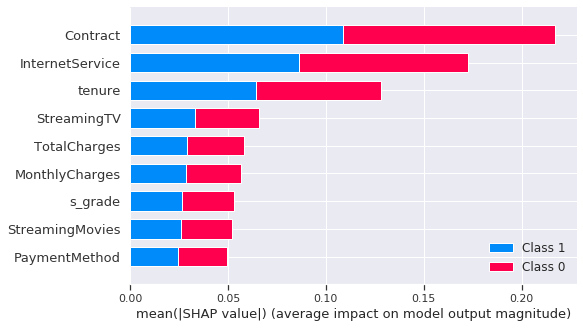

In [ ]:
shap_values = explainer.shap_values(X_train_encoded)
shap.summary_plot(shap_values, X_test_selected, plot_type='bar')

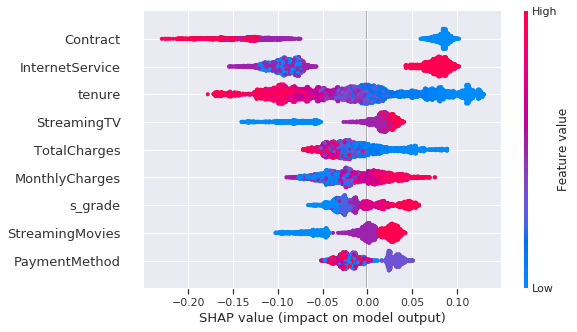

In [ ]:
shap.initjs()
shap.summary_plot(shap_values[1], X_train_encoded, plot_type='dot')

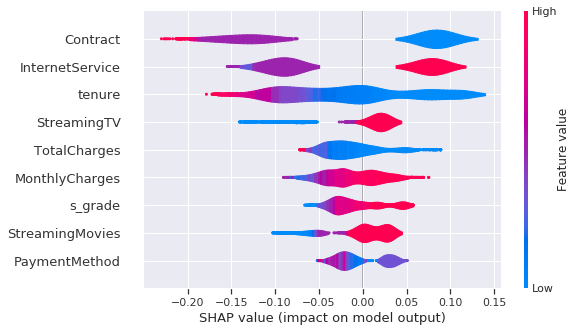

In [ ]:
shap.initjs()
shap.summary_plot(shap_values[1], X_train_encoded, plot_type="violin")

- `Contract`는 Positive(이탈), `InternetService`는 Negative(이탈하지 않음)을 잘 분류해주는 feature이다.

- SHAP은 순열 중요도와 달리 여러 조합에 대해 종합적으로 평균을 내서 feature importance를 구한 것